# BYOL

## SETUP

In [1]:
%cd ~/Documents/TESI/TESI/notebooks
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/TESI/notebooks


/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import tifffile
import glob
import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
)

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False:


2.6.0+cu124
1.4.0


In [3]:
from utils.setup_functions import set_environment_flags
# Example usage:
environment_flags = set_environment_flags()
kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

Environment settings: {'gdrive': False, 'linux': True, 'kaggle': False, 'ssl': True}


In [4]:
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [5]:
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))
from utils.directory_functions import get_data_and_base_directory
data_dir, base_dir = get_data_and_base_directory(environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"], num_input_channels=num_input_channels)

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new


# DATA EXTRACTION

In [6]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [26]:
## Paths of ALL images into a numpy array without labels used for SSL
def from_tif_folder_to_np_paths_array(folder_path: str) -> np.ndarray:
    """
    Load all .tif images from a folder into a numpy array.
    """
    image_paths = glob.glob(os.path.join(folder_path, "*.tif"))
    image_paths_np = np.array(image_paths)
    print(f"Number of images in {folder_path}: {len(image_paths)}")
    return image_paths_np

all_images_folder_path = os.path.join(data_dir, "ALL")
all_images_paths = from_tif_folder_to_np_paths_array(all_images_folder_path)
print("Number of images in ALL folder:", len(all_images_paths))

Number of images in /home/zano/Documents/TESI/3c_MIP_new/ALL: 152
Number of images in ALL folder: 152


In [27]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    

ssl_images_paths_np = from_tif_folder_to_np_paths_array(ssl_images_folder_path)
print(f"Number of images in {ssl_images_folder_path} folder:", len(ssl_images_paths_np))

['MSA-P', 'PD']
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL+MSA-C: 54
Number of images in /home/zano/Documents/TESI/3c_MIP_new/CONTROL+MSA-C folder: 54


{'MSA-P': '/home/zano/Documents/TESI/3c_MIP_new/MSA-P', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
Class directories:
{'MSA-P': '/home/zano/Documents/TESI/3c_MIP_new/MSA-P', 'PD': '/home/zano/Documents/TESI/3c_MIP_new/PD'}
MSA-P images (before filtering): 'gh' count: 48, 'vaso' count: 0
Number of glandular images before filtering: 48
Number of glandular images after filtering: 48
PD images (before filtering): 'gh' count: 57, 'vaso' count: 0
Number of glandular images before filtering: 57
Number of glandular images after filtering: 57


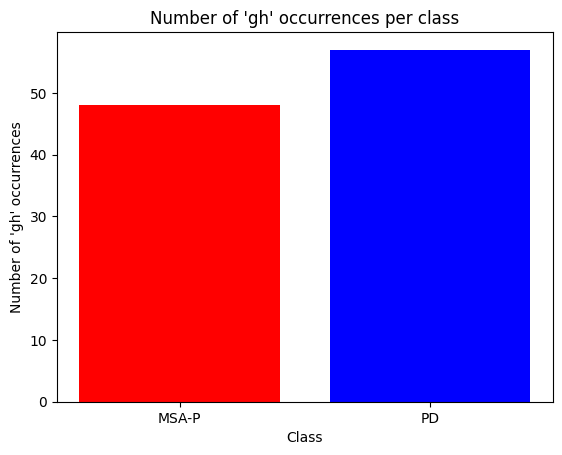


Checking image shapes:
MSA-P image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5435 gh.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5435 gh2.tif.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5717.lif - 5717 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh 2 pinhole 1 z 05.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5717.lif - 5717 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh pinhole 1 z 05.tif  dtype: uint8, shape: (3, 1024, 1024)
MSA-P image: MAX_5

In [28]:
# Create a dictionary mapping each class to its directory
class_dirs = {} # { "class_name": "path/to/class_dir", "class_name2": "path/to/class_dir2", ... }
is_three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if is_three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    from utils.data_extraction_functions import remove_non_gland_images
    image_paths = remove_non_gland_images(image_paths)
    # counts after filtering
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    # print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
# def plot_counts_bar_chart(counts_dict, class_names):
#     """
#     Plot a bar chart of counts for each class.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_names, [counts_dict[cn]["gh_count"] for cn in class_names], color='blue')
#     plt.xlabel("Class")
#     plt.ylabel("Number of 'gh' occurrences")
#     plt.title("Number of 'gh' occurrences per class")
#     plt.show()

plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
# random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts.keys(), key=lambda k: counts[k])
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

Original dataset size: 105
Original label distribution: {0: 48, 1: 57}

Aiming for a balanced test set with 48 samples per class.
Total balanced test set size will be: 96
Test set size: 96

Test set distribution: {0: 48, 1: 48}


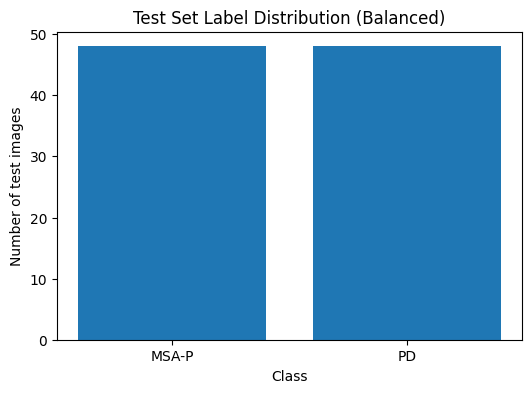


Test set counts and percentages:
MSA-P: 48 images (50.0% of test set)
PD: 48 images (50.0% of test set)


In [29]:
# --- Your Split Logic for 50/50 distribution in test set ---
print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

89 training images
16 test images
<class 'numpy.ndarray'>


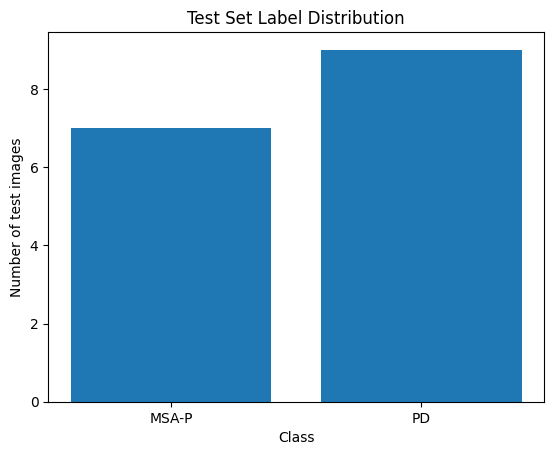

Label 0 (MSA-P): 7 images
Label 1 (PD): 9 images
Label 0 (MSA-P) is: 0.4375
Label 1 (PD) is: 0.5625


In [30]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= 0.15,
    stratify=labels,
    random_state=42,
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
# print("train images paths:", train_images_paths)
# print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
# print(test_images_paths)
print(type(train_images_paths))

unique_labels, counts = np.unique(test_true_labels_np, return_counts=True)


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [31]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id)

display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

image_path  label patient_id
0    /home/zano/Documents/TESI/3c_MIP_new/MSA-P/MAX...      0       4121
1    /home/zano/Documents/TESI/3c_MIP_new/MSA-P/MAX...      0       4121
2    /home/zano/Documents/TESI/3c_MIP_new/MSA-P/MAX...      0       5358
3    /home/zano/Documents/TESI/3c_MIP_new/MSA-P/MAX...      0       5358
4    /home/zano/Documents/TESI/3c_MIP_new/MSA-P/MAX...      0       5435
..                                                 ...    ...        ...
100  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_74...      1       7461
101  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_75...      1       7544
102  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...      1       7677
103  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_76...      1       7688
104  /home/zano/Documents/TESI/3c_MIP_new/PD/MAX_77...      1       7710

[105 rows x 3 columns]

Unique patient IDs: ['4121' '5358' '5435' '5717' '5745' '5753' '5767' '5776' '5878' '5978'
 '5992' '6008' '6053' '6179' '6308' '6311' '6320' '6323' '6326' '6337'
 '6340' '6351' '6363' '6366' '6375' '6383' '6424' '6427' '6459' '6485'
 '6571' '6577' '6593' '6599' '6616' '6651' '6657' '6690' '6696' '6749'
 '6773' '6791' '7120' '7132' '7144' '7155' '7222' '7229' '7284' '7343'
 '7461' '7544' '7677' '7688' '7710']
Number of unique patients: 55
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1]


patient_id  label
0        4121      0
1        5358      0
2        5435      0
3        5717      0
4        5745      0
5        5753      0
6        5767      0
7        5776      0
8        5878      0
9        5978      0
10       5992      0
11       6008      1
12       6053      0
13       6179      0
14       6308      0
15       6311      0
16       6320      1
17       6323      1
18       6326      0
19       6337      1
20       6340      1
21       6351      1
22       6363      1
23       6366      1
24       6375      1
25       6383      1
26       6424      1
27       6427      1
28       6459      1
29       6485      0
30       6571      1
31       6577      1
32       6593      0
33       6599      0
34       6616      1
35       6651      1
36       6657      0
37       6690      1
38       6696      1
39       6749      1
40       6773      1
41       6791      1
42       7120      0
43       7132      0
44       7144      0
45       7155      1
46       7222      1
47       7229      1
48       7284      1
49       7343      0
50       7461      1
51       7544      1
52       7677      1
53       7688      1
54       7710      1

## BYOL & SIMSIAM

BYOL (Bootstrap Your Own Latent) is another Self-Supervised Learning (SSL) approach that aims to learn meaningful representations from unlabeled data. Unlike SimCLR, BYOL does not require negative samples, which simplifies the training process and reduces the need for large batch sizes.

The goals of BYOL are:
* Learn robust and meaningful embeddings from microscopy images.
* Improve generalization by leveraging structural patterns in the data.

The implementation consists of:
* A BYOL dataset returning augmented pairs.
* Using a target network and an online network to learn representations by minimizing the difference between their outputs.
* Training a ResNet-based BYOL model with a predictor network to improve performance.

Once the model is trained:
* The target network is discarded.
* The online network is fine-tuned with labeled data using a linear classifier.

BYOL improves upon SimCLR in several ways:
* It does not require negative samples, reducing the need for large batch sizes.
* It is less sensitive to the choice of data augmentations.
* It can achieve competitive performance with smaller batch sizes and less computational resources.

### Problems of BYOL
* Still computationally expensive, though less so than SimCLR.
* The quality of learned representations depends on the quality and diversity of the unlabeled data.
* May not work well if the unlabeled data is very different from the labeled data.

Note: the Online network is also called student while the target is called teacher

![alt text](image.png)

![image.png](attachment:image.png)

Training Loop in a Nutshell
1. Augment your Image Twice

    For each sample x, create two augmented versions: x1 and x2.
2. Forward Pass

    Student sees x1 → outputs z1 (encoder + projector), then p1 (predictor).
    
    Teacher sees x2 → outputs z2 (encoder + projector).
3. Loss Function

    - BYOL aims to match p1 with z2 (stop-gradient on the teacher side).
    - Symmetry: Then do the reverse pass (Teacher sees x1, Student sees x2) and combine losses.
    - Final loss is a mean squared error between normalized p1 and z2, plus the symmetrical term.

4. Update Student Weights

    - Standard backprop on the Student network.

5. Momentum Update

    - Update the Teacher’s weights with the exponential moving average.
6. Repeat for all images in the dataset.

    - Typically we do many epochs to learn stable representations.

* implement SIMCLR, BYOL, MOCO, BIG SSL MODEL
* Evaluate resulted features via K-NN, K-mean, Linear classifier

<span style="font-size: 1.5em;">**DOWNSTREAM CLASSIFICATION**</span>

After you’ve done BYOL pretraining for some epochs:

1. Freeze the BYOL encoder (i.e., model.online_encoder).
2. Add a classifier head for PD vs. MSA.
3. Train that classifier with your limited labeled data.

In [13]:
## TODO try Patch-based training for BYOL. Extract multiple patches from each 2D MIP to effectively increase your dataset size.
## TODO Using pretrained 2D ResNet weights as a starting point, then apply BYOL (or SSL more in general).
## TODO choosing the right augmentations

### USING THE REPO BYOL (https://github.com/lucidrains/byol-pytorch)

In [32]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [33]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL+MSA-C")
else:
    ssl_images_folder_path = os.path.join(data_dir, "CONTROL")
    
ssl_images_paths = glob.glob(os.path.join(ssl_images_folder_path, "*.tif"))
ssl_images_paths_np = np.array(ssl_images_paths)
print("Number of images in ALL folder:", len(ssl_images_paths))

['MSA-P', 'PD']
Number of images in ALL folder: 54


Batch type: <class 'monai.data.meta_tensor.MetaTensor'>
Images shape: torch.Size([3, 256, 256])
Original image tensor shape #15: torch.Size([3, 512, 512])


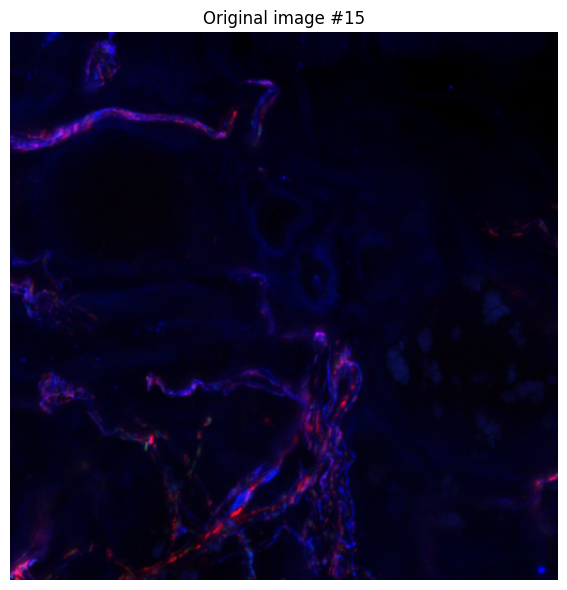

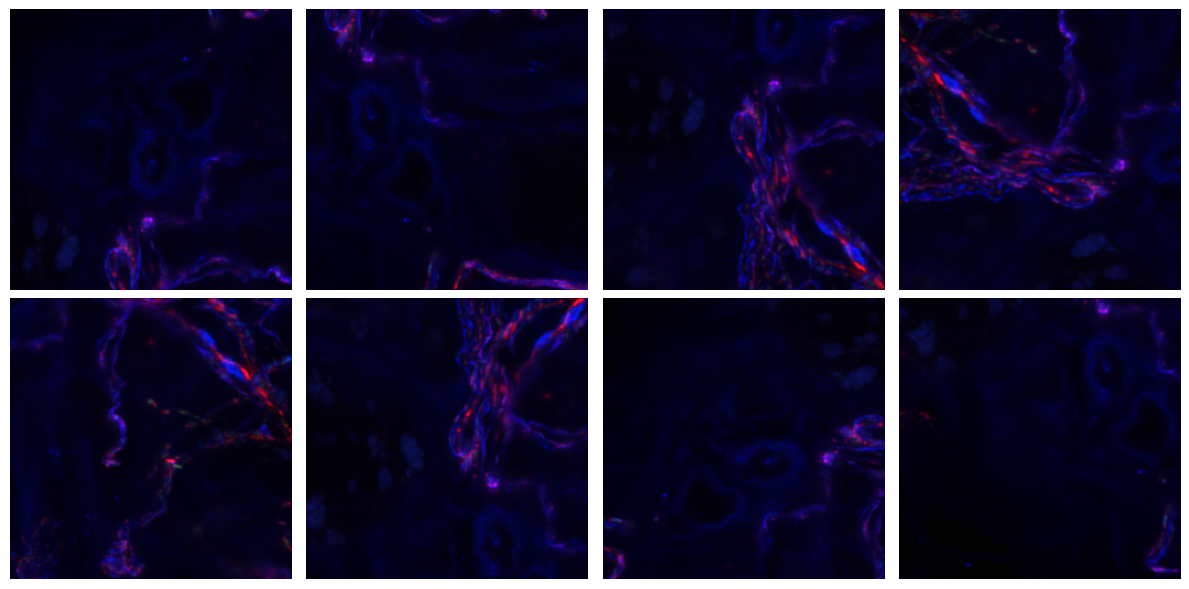

In [34]:
from monai.transforms import (
    Compose,
    # EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    RandFlip,                    
    RandRotate90,  
    EnsureTyped,              
)
from monai.transforms.utility.dictionary import LambdaD

from monai.transforms.croppad.array import RandSpatialCropSamples  # pure sampler
from monai.data.grid_dataset import PatchDataset
import matplotlib.pyplot as plt
import torch, itertools, math, numpy as np

# ------------------------------------------------------------------
# a) 1‑per‑image dicts with a path under key "image"
# ------------------------------------------------------------------

dataset_ssl = [{"image": path} for path in ssl_images_paths_np]

# ------------------------------------------------------------------
# b) image‑level transforms 
# ------------------------------------------------------------------
from utils.transformations_functions import from_GBR_to_RGB
from classes.CustomTiffFileReader import CustomTiffFileReader

img_tf = Compose([
    CustomTiffFileReader(keys=["image"]), # loads the image from the path as a numpy array (C,H,W) in GBR format
    EnsureTyped(keys=["image"], data_type="tensor", dtype=torch.float32), # Ensure image is a tensor
    LambdaD(keys="image", func=from_GBR_to_RGB),
    # EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=(512, 512)),
    ScaleIntensityd(keys="image"),
])

# ------------------------------------------------------------------
# c) patch sampler : 8 random 256×256 crops — pure (non‑dict) version
# ------------------------------------------------------------------
sampler = RandSpatialCropSamples(
    roi_size=(256, 256),
    num_samples=8,
    random_center=True,
    random_size=False,
)

# ------------------------------------------------------------------
# d) patch‑level augments
# ------------------------------------------------------------------
    
patch_tf = Compose([
    # RandChannelShift(max_shift=15, prob=0.70),
    RandFlip(spatial_axis=0, prob=0.5),  
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate90(max_k=3, prob=0.5),
])

# ------------------------------------------------------------------
# e) PatchDataset – extract the Tensor, sample, then augment
# ------------------------------------------------------------------
patch_ds = PatchDataset(
    data=dataset_ssl,                                             # use named arg `data`
    # dataset=img_ds,                                             # use named arg `dataset`
    samples_per_image=8,                                        # produces 8 patches per image
    patch_func=lambda d: sampler(img_tf(d)["image"]),           # <-- pull out d["image"]
    transform=patch_tf,                                         # augment each pure Tensor
)
#testing porpouses
first_batch = next(iter(patch_ds))
print(f"Batch type: {type(first_batch)}") #Batch type: <class 'monai.data.meta_tensor.MetaTensor'>
print(f"Images shape: {first_batch.shape}") # Batch shape: torch.Size([8, 3, 256, 256])

# ------------------------------------------------------------------
# helper to visualise the 8 patches from image `img_idx`
# ------------------------------------------------------------------
def show_patches(
    ds,
    img_idx: int = 0,
    n_patches: int = 8,
    show_original: bool = False
):
    """
    Display random cropped patches (and optionally the original image)
    for the image at index `img_idx` in a PatchDataset.

    Parameters
    ----------
    ds : monai.data.PatchDataset
        A PatchDataset yielding Tensor patches (C, H, W).
    img_idx : int, optional
        Zero-based index of which source image to pull patches from.
        Default is 0.
    n_patches : int, optional
        How many patches were sampled per image (so for slicing the iterator).
        Default is 8.
    show_original : bool, optional
        If True, will display the full pre‑processed image before the patches.
        Default is False.

    Raises
    ------
    ValueError
        If `img_idx` is out of range (i.e. no patches found).
    """
    # -- optionally show the original full‐image (after img_tf) --
    if show_original:
        # pull the same dict you used to build patch_ds
        d = dataset_ssl[img_idx] # get the img_idx element of the list of dictionaries ie  {"image": path_idx}
        # print(d) #{ "image": "path"}
        image_tensor = img_tf(d)["image"]           # apply the image-level transforms to the image ternsor ie d["image"] ie load the tensor associated to that path
        print(f"Original image tensor shape #{img_idx}: {image_tensor.shape}") # Print the shape of the tensor
        # visualize_tiff(img_ds[img_idx]["image"]) # Use your custom function to visualize the TIFF image
        # print(f"Original image shape #{img_idx}: {d["image"].shape}")
        img = image_tensor.cpu().numpy().transpose(1, 2, 0)  # H×W×C to plot
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Original image #{img_idx}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # -- now grab the n_patches for that image index --
    start = img_idx * n_patches
    end   = start + n_patches
    stream = itertools.islice(iter(ds), start, end) # iterator of Tensors
    patches = [p.cpu() for p in stream] # list of Tensors

    if not patches:
        raise ValueError(f"img_idx {img_idx} out of range (no patches)")

    # -- plot the patches in a grid --
    n_cols = 4
    n_rows = math.ceil(n_patches / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(3 * n_cols, 3 * n_rows))
    for ax, patch in zip(axes.flat, patches):
        img = patch.numpy().transpose(1, 2, 0)  # H×W×C
        ax.imshow(img)
        ax.axis("off")

    # blank out any leftover axes
    for ax in axes.flat[len(patches):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# show original + patches from the 3rd image
show_patches(patch_ds, img_idx=15, n_patches=8, show_original=True)

In [35]:
from monai.data import Dataset, DataLoader
from numpy import stack
from classes.PrintShapeTransform import PrintShapeTransform
from classes.CustomTiffFileReader import CustomTiffFileReader

base_transforms = train_transforms

# Wrap your patch_ds with a custom collate function that returns dictionaries
# it tells the DataLoader how to combine the individual patches into a batch of dictionaries
# alternative to this is just to not use dictinary transform but array transforms 
def dict_collate_fn(batch):
    #stack the images in the batch and return a dictionary
    stacked_images = torch.stack(batch, 0)
    dummy_labels = torch.zeros(stacked_images.size(0), dtype=torch.long) # Dummy label, not used in SSL
    return {"image": stacked_images, "label": dummy_labels} # This assumes each item in the batch is a dictionary with an "image" key.


BATCH_SIZE = 16  # Define your batch size

# Create the patch-based DataLoader
train_loader_patch_ds = DataLoader(
    patch_ds,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=dict_collate_fn  #tells the DataLoader how to combine the individual patches into a batch of dictionaries
)

#testing porpouses
# first_batch = next(iter(train_loader_patch_ds))
# print(f"Batch type: {type(first_batch)}") #Batch type: <class 'dict'>
# print(f"Batch keys: {first_batch.keys()}") #dict_keys(['image','label'])
# print(f"Images shape: {first_batch['image'].shape}")  #torch.Size([16, 3, 256, 256])

# Create the full-image DataLoader
from utils.train_functions import make_unlabeled_loader
train_loader_full_ds = make_unlabeled_loader(
    image_paths=ssl_images_paths_np,
    transforms=base_transforms,
    cfg=cfg,
    shuffle=True,
)
# print("FULL IMAGE DATASET")
# first_batch = next(iter(train_loader_full_ds))
# print(f"Batch type: {type(first_batch)}") #Batch type: <class 'dict'>
# print(f"Batch keys: {first_batch.keys()}") #dict_keys(['image'])
# print(f"Images shape: {first_batch['image'].shape}")  #torch.Size([16, 3, 256, 256])
# print(type(train_loader))

In [36]:
import ipywidgets as widgets
from IPython.display import display
# Dictionary to map dropdown options to loaders
loader_options = {
    "Patch DataLoader": train_loader_patch_ds,
    "Full Image DataLoader": train_loader_full_ds,
}

# Dropdown widget for loader selection
loader_dropdown = widgets.Dropdown(
    options=list(loader_options.keys()),
    value="Patch DataLoader",
    description="Train Loader:",
    style={'description_width': 'initial'},
)

# Variable to hold the selected loader
train_loader = loader_options[loader_dropdown.value]

def on_loader_change(change):
    """
    Callback to update the train_loader variable when the dropdown changes.
    """
    global train_loader
    train_loader = loader_options[change['new']]
    print(f"train_loader set to: {change['new']} ({type(train_loader)})")

# Attach the callback to the dropdown
loader_dropdown.observe(on_loader_change, names='value')

display(loader_dropdown)
print(f"Initial train_loader: {loader_dropdown.value} ({type(train_loader)})")

Dropdown(description='Train Loader:', options=('Patch DataLoader', 'Full Image DataLoader'), style=Description…

Initial train_loader: Patch DataLoader (<class 'monai.data.dataloader.DataLoader'>)


In [37]:
# Check the type of the train_loader and shape of the returned batches
print(type(train_loader))  # Should be a DataLoader
for batch in train_loader:
    print(f"Batch type: {type(batch)}")  # Should be a dictionary
    print(f"Batch keys: {batch.keys()}")  # Should contain 'image' and possibly 'label'
    print(f"Images shape: {batch['image'].shape}")  # Should be [BATCH_SIZE, C, H, W]
    assert batch['image'].shape == torch.Size([BATCH_SIZE, 3, 256, 256]), "Batch size mismatch!"
    break  # Just show the first batch for now

<class 'monai.data.dataloader.DataLoader'>
Batch type: <class 'dict'>
Batch keys: dict_keys(['image', 'label'])
Images shape: torch.Size([16, 3, 256, 256])


In [20]:
# import kornia.augmentation as K
# import kornia.filters as KF

# _final_resize = K.Resize(size=(256, 256))

# # ──────────────────────────────
# # View 1 — “global crop”
# # ──────────────────────────────
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Common safeguard: always finish at 256 × 256
# _final_resize = K.Resize(size=(256, 256), antialias=True)

# # ──────────────────────────────
# # View 1 — “global crop”
# # ──────────────────────────────
# augment_fn = nn.Sequential(
#     # Multi-scale global crop (55–100 % area)
#     K.RandomResizedCrop(
#         size=(256, 256), scale=(0.55, 1.0), ratio=(1.0, 1.0), p=1.0
#     ),

#     # Geometric invariances
#     K.RandomHorizontalFlip(p=0.5),
#     K.RandomVerticalFlip(p=0.5),
#     K.RandomRotation(degrees=180.0, resample="bilinear", p=0.5),

#     # # Mild tissue-like deformation
#     # K.RandomElasticTransform(
#     #     kernel_size=(75, 75),      # coarser grid → smoother field
#     #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
#     #     alpha=(2.0, 4.0),          # 2-4 px average displacement
#     #     p=0.20,
#     #     align_corners=False,
#     #     padding_mode="border",
#     # ),

#     # Image-formation perturbations
#     K.RandomGaussianBlur(kernel_size=(5, 5), sigma=(0.2, 1.2), p=0.50),
#     # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
#     K.RandomGaussianNoise(mean=0.0, std=0.015, p=0.40),

#     # Intensity jitter (per-channel invariance)
#     K.ColorJiggle(brightness=(0.8, 1.2), contrast=(0.8, 1.2), p=0.40),
#     # K.RandomGamma(gamma=(0.8, 1.2), p=0.30),

#     # Channel robustness
#     K.RandomChannelDropout(num_drop_channels=1, p=0.20),
#     # Occlusion regularisation  
#     K.RandomErasing(
#         scale=(0.02, 0.08),
#         ratio=(0.3, 3.3),
#         same_on_batch=False,
#         # value="random",  # coloured blocks instead of black
#         p=0.15,
#     ),
    

#     _final_resize,  # ensure 256 × 256 output
# ).to(device)

# # ──────────────────────────────
# # View 2 — “local crop + deformation”
# # ──────────────────────────────
# augment_fn2 = nn.Sequential(
#     # Tighter crop (35–60 % area)
#     K.RandomResizedCrop(
#         size=(256, 256), scale=(0.35, 0.60), ratio=(1.0, 1.0), p=1.0
#     ),

#     # Mild illumination & contrast jitter before geometry
#     K.ColorJiggle(brightness=(0.85, 1.15), contrast=(0.85, 1.15), p=0.50),

#     # Geometric invariances
#     K.RandomAffine(
#         degrees=0.0,
#         translate=(0.05, 0.05),
#         scale=(0.90, 1.10),
#         shear=(3.0, 3.0),
#         padding_mode="border",
#         p=0.50,
#     ),
    
#     # K.RandomElasticTransform(
#     #     kernel_size=(75, 75),      # coarser grid → smoother field
#     #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
#     #     alpha=(2.0, 4.0),          # 2-4 px average displacement
#     #     p=0.20,
#     #     align_corners=False,
#     #     padding_mode="border",
#     # ),

#     # Focus & noise perturbations
#     K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0), p=0.50),
#     # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
#     K.RandomGaussianNoise(mean=0.0, std=0.020, p=0.60),

#     # Channel robustness
#     K.RandomChannelDropout(num_drop_channels=1, p=0.30),

#     # Occlusion regularisation
#     K.RandomErasing(
#         scale=(0.03, 0.10),
#         ratio=(0.3, 3.3),
#         same_on_batch=False,
#         # value="random",
#         p=0.20,
#     ),

#     _final_resize,
# ).to(device)

To fetch the embeddings or the projections, you simply have to pass in a return_embeddings = True flag to the BYOL learner instance


```python
resnet = models.resnet50(pretrained=True)

learner = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool'
)

imgs = torch.randn(2, 3, 256, 256)
projection, embedding = learner(imgs, return_embedding = True)
```

or

```python

# 1) Load your BYOL-pretrained ResNet
model = models.resnet50(pretrained=False)
model.load_state_dict(torch.load('byol_pretrained_resnet.pth'))

# 2) (Optional) Remove the final FC if you want raw 2048-d features
model.fc = nn.Identity()

model = model.to('cuda')
model.eval()

# 3) Pass images through for embeddings
with torch.no_grad():
    embeddings = model(your_images_tensor)  # shape: (B, 2048) if you removed fc
    ```

In [38]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "torchvision" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [39]:
from classes.MonaiNdTransformAdapter import MonaiNdTransformAdapter
from utils.ssl.byol_transformation_functions import get_byol_transforms_nd

normalize_intensity = False  # Set to True if you want to normalize intensity
monai_view1_compose, monai_view2_compose = get_byol_transforms_nd(cfg, normalize_intensity=normalize_intensity)
type_of_transform = "monai_non_dict"
# // Wrap the MONAI Compose objects
wrapped_monai_view1_transform = MonaiNdTransformAdapter(monai_view1_compose)
wrapped_monai_view2_transform = MonaiNdTransformAdapter(monai_view2_compose)

# // Determine the device (consistent with your Kornia setup and BYOL learner)
# This device should be the same as the one used for your Kornia augmentations and the BYOL learner
# You might already have 'device' defined from cell '9288ea70' or when setting up the model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# // Move the wrapped MONAI transforms to the device
augment_fn = wrapped_monai_view1_transform.to(current_device)
augment_fn2 = wrapped_monai_view2_transform.to(current_device)

# // Now, 'augment_fn' and 'augment_fn2' are nn.Modules on the correct device,
# // and can be passed to the BYOL learner in cell 'f5012178'.
# // This replaces the previous assignment:
# // augment_fn=monai_view1_transform
# // augment_fn2=monai_view2_transform

print(f"MONAI augment_fn type: {type(augment_fn)}, device: {next(augment_fn.parameters()).device if list(augment_fn.parameters()) else 'No parameters, device assumed from input'}")
print(f"MONAI augment_fn2 type: {type(augment_fn2)}, device: {next(augment_fn2.parameters()).device if list(augment_fn2.parameters()) else 'No parameters, device assumed from input'}")

MONAI augment_fn type: <class 'classes.MonaiNdTransformAdapter.MonaiNdTransformAdapter'>, device: No parameters, device assumed from input
MONAI augment_fn2 type: <class 'classes.MonaiNdTransformAdapter.MonaiNdTransformAdapter'>, device: No parameters, device assumed from input


In [40]:
from utils.ssl.byol_transformation_functions import get_byol_transforms_dict
from classes.MonaiDictTransformAdapter import MonaiDictTransformAdapter

# Get the MONAI Compose objects for dictionary-based transforms
normalize_intensity = False  # Set this based on your needs
monai_view1_dict_transform, monai_view2_dict_transform = get_byol_transforms_dict(cfg, normalize_intensity=normalize_intensity)
type_of_transform = "monai_dict"
# Wrap the MONAI Compose objects
# You might need to inspect monai_view1_dict_transform to confirm the exact image key if it's not "image"
# For example, if your get_byol_transforms_dict creates transforms that use a different key, adjust "image" accordingly.
wrapped_monai_view1_transform = MonaiDictTransformAdapter(monai_view1_dict_transform, image_key="image")
wrapped_monai_view2_transform = MonaiDictTransformAdapter(monai_view2_dict_transform, image_key="image")

# Determine the device
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Move the wrapped MONAI transforms to the device
augment_fn = wrapped_monai_view1_transform.to(current_device)
augment_fn2 = wrapped_monai_view2_transform.to(current_device)

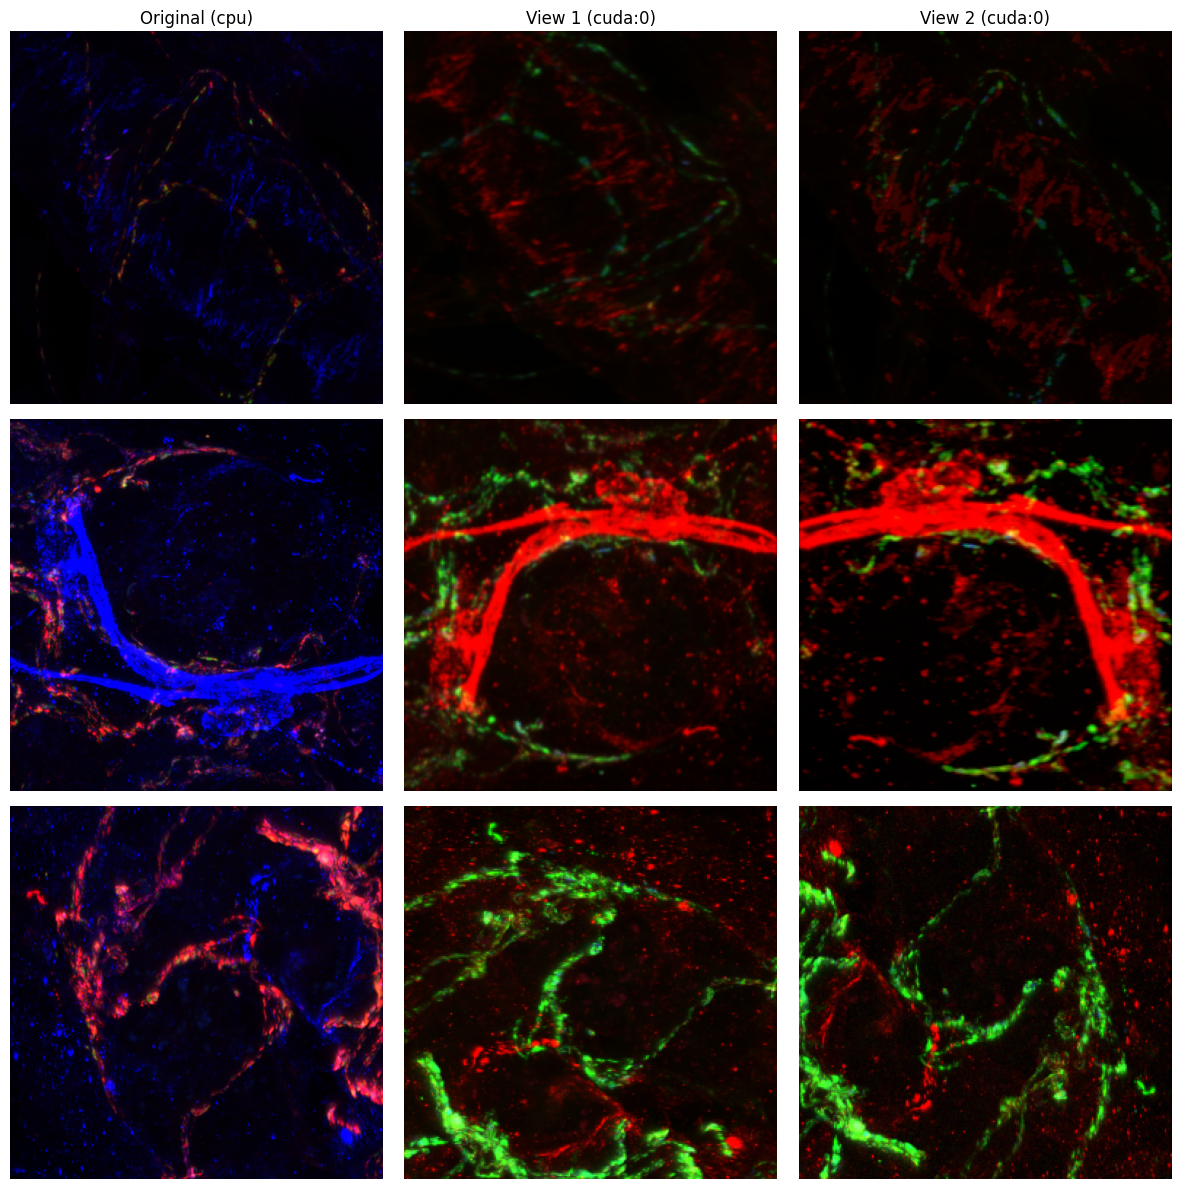

(metatensor([[[[0.0078, 0.0088, 0.0078,  ..., 0.0127, 0.0196, 0.0127],
           [0.0088, 0.0088, 0.0098,  ..., 0.0147, 0.0176, 0.0147],
           [0.0098, 0.0078, 0.0069,  ..., 0.0186, 0.0196, 0.0206],
           ...,
           [0.0118, 0.0118, 0.0088,  ..., 0.0098, 0.0118, 0.0108],
           [0.0108, 0.0118, 0.0108,  ..., 0.0108, 0.0098, 0.0118],
           [0.0088, 0.0118, 0.0127,  ..., 0.0108, 0.0127, 0.0167]],
 
          [[0.0029, 0.0029, 0.0059,  ..., 0.0059, 0.0049, 0.0039],
           [0.0010, 0.0010, 0.0010,  ..., 0.0049, 0.0020, 0.0039],
           [0.0020, 0.0049, 0.0000,  ..., 0.0039, 0.0049, 0.0029],
           ...,
           [0.0029, 0.0020, 0.0010,  ..., 0.0039, 0.0010, 0.0020],
           [0.0020, 0.0049, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
           [0.0000, 0.0000, 0.0010,  ..., 0.0000, 0.0010, 0.0000]],
 
          [[0.1039, 0.0569, 0.0382,  ..., 0.0578, 0.0618, 0.0578],
           [0.1029, 0.0451, 0.0373,  ..., 0.0559, 0.0618, 0.0539],
           [0.0559, 

In [24]:
@torch.no_grad()
def viz_augmented_views_monai(
    sample_idx: int,
    augment_fn,
    augment_fn2,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    num_images: int = 1,
    dataset_ssl=dataset_ssl,  # Reference your dataset_ssl from earlier
    img_loader_transform=img_tf # Reference img_tf for loading original images
):
    """
    Visualize original images and their augmented views using MONAI dictionary-based transforms
    that expect an already loaded image tensor in their input dictionary.

    Parameters:
    -----------
    sample_idx : int
        Index of the sample in dataset_ssl to start visualization from.
    augment_fn : monai.transforms.Compose
        The first MONAI dictionary-based augmentation pipeline (e.g., from get_byol_transforms_dict).
        It expects an input dictionary like {"image": torch.Tensor, "label": ...}
        where the "image" is an already loaded and preprocessed tensor, and
        returns an augmented dictionary {"image": torch.Tensor, ...}.
    augment_fn2 : monai.transforms.Compose
        The second MONAI dictionary-based augmentation pipeline, with the same
        characteristics as augment_fn.
    device : str or torch.device, optional
        The device to move tensors to before applying augmentations if necessary,
        though dictionary transforms might handle device internally or expect CPU input.
        Defaults to "cuda" if available, otherwise "cpu".
    num_images : int, optional
        Number of images to show. Defaults to 1.
    dataset_ssl : List[Dict[str, str]], optional
        A list of dictionaries, where each dictionary must have an "image" key
        with a file path string. Defaults to the `dataset_ssl` in the global scope.
    img_loader_transform : monai.transforms.Compose, optional
        A MONAI dictionary-based transform pipeline for loading and initial
        preprocessing of images from paths (e.g., global `img_tf`).
        It expects a Dict {"image": path_str, ...} and returns a
        Dict {"image": torch.Tensor, ...}. Defaults to `img_tf`.

    Returns:
    --------
    Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        A tuple containing:
        - orig_batch: Batch of original images as a torch.Tensor
                      (shape (num_images, C, H, W)), on CPU.
        - view1_batch: Batch of augmented view1 images as a torch.Tensor
                       (shape (num_images, C, H, W)), likely on CPU or device
                       depending on the last transform in augment_fn.
        - view2_batch: Batch of augmented view2 images as a torch.Tensor
                       (shape (num_images, C, H, W)), similar to view1_batch.
    """
    # Get the file paths for the images to visualize
    paths = []
    for i in range(sample_idx, min(sample_idx + num_images, len(dataset_ssl))):
        paths.append(dataset_ssl[i]["image"])  # Get original file paths

    # Load original images and prepare input dictionaries for augmentation
    loaded_image_dicts = []
    for path in paths:
        # img_loader_transform loads the image from path and returns a dict {"image": tensor, "label": ...}
        # The tensor is typically on CPU after loading.
        # We add a dummy label as some MONAI dict transforms might expect it.
        loaded_dict = img_loader_transform({"image": path, "label": 1})
        loaded_image_dicts.append(loaded_dict)
    
    orig_batch_cpu = torch.stack([d["image"] for d in loaded_image_dicts]) # Shape: (num_images, C, H, W), on CPU

    # Apply augmentation pipelines
    view1_augmented_tensors_list = []
    for loaded_dict in loaded_image_dicts:
        # Create a copy to avoid modifying the original loaded_dict if augment_fn works in-place
        input_dict_for_aug = {k: v.clone().to(device) if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}
        # Or, if augment_fn expects CPU tensors and handles device transfer internally:
        # input_dict_for_aug = {k: v.clone() if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}
        
        augmented_dict = augment_fn(input_dict_for_aug)
        view1_augmented_tensors_list.append(augmented_dict["image"])
    
    view1_batch = torch.stack(view1_augmented_tensors_list)

    view2_augmented_tensors_list = []
    for loaded_dict in loaded_image_dicts:
        input_dict_for_aug = {k: v.clone().to(device) if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}
        # Or, if augment_fn2 expects CPU tensors:
        # input_dict_for_aug = {k: v.clone() if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}

        augmented_dict = augment_fn2(input_dict_for_aug)
        view2_augmented_tensors_list.append(augmented_dict["image"])
        
    view2_batch = torch.stack(view2_augmented_tensors_list)

    # Plot the results
    n_rows = num_images
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
    titles = ["Original", "View 1", "View 2"]
    
    for r in range(n_rows):
        imgs_to_plot = [orig_batch_cpu[r], view1_batch[r], view2_batch[r]]
        
        for c, img_tensor in enumerate(imgs_to_plot):
            ax = axes[r, c] if n_rows > 1 else axes[c]
            img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)  # CHW to HWC
            ax.imshow(np.clip(img_np, 0, 1))
            
            if r == 0:
                current_title = f"{titles[c]} ({img_tensor.device})"
                ax.set_title(current_title)
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    return orig_batch_cpu, view1_batch, view2_batch

# Visualize transformations on a few samples
viz_augmented_views_monai(0, monai_view1_dict_transform, monai_view2_dict_transform, num_images=3)

In [41]:
from byol_pytorch import BYOL
from torchvision import models
import time
# resnet = models.resnet50(weights = None)  # or pretrained=True if you like
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

#usage Simply plugin your neural network, specifying 
# (1) the image dimensions
# (2) the name (or index) of the hidden layer, 
# whose output is used as the latent representati
# this library will use the augmentations from the SimCLR paper (which is also used in the BYOL paper).
# learner = BYOL(
#     resnet,
#     image_size = 256,          # the height & width of your input images
#     augment_fn = custom_augment_fn,
#     augment_fn2 = custom_augment_fn,  # or define a second pipeline if desired
#     hidden_layer = 'avgpool',  # output layer used for representation
#     # projection_size = 256,     # defaults to 256
#     # projection_hidden_size = 4096,
#     # moving_average_decay = 0.99
# )

simsiam = True

if not simsiam:
    print("BYOL")
    learner = BYOL(
        net=model,
        image_size=256,           # must match your input size
        hidden_layer='avgpool',   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        projection_size=256,
        projection_hidden_size=4096,
        moving_average_decay=0.99
    )
else:
    print("SimSiam")
    learner = BYOL(
        net=model,
        image_size=256,  # must match your input size
        hidden_layer=-2, #or "avgpool"   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        # projection_size=256,
        # projection_hidden_size=4096,
        # moving_average_decay=0.99
        use_momentum=False, # This is the main difference from byol
    ) 

device = "cuda" if torch.cuda.is_available() else "cpu"
learner = learner.to(device)
optimizer = optim.Adam(learner.parameters(), lr=1e-4)
scaler = torch.GradScaler("cuda")  # for mixed precision training

start_time = time.time()
#Encoder Pre-training loop
patience          = 25          
best_train_loss   = float("inf")
epochs_no_improve = 0
best_state_dict   = None

num_epochs = 120
for epoch in range(1, num_epochs + 1):
    learner.train()
    total_loss = 0.0
    for batch in train_loader:
        #load the images from the batch ()
        imgs = batch["image"].to(device)
        # print(f"Batch shape: {imgs.shape}")  # Should be [batch_size, 3, 256, 256]

        with torch.autocast(device_type=device, dtype=torch.float16):
            loss = learner(imgs)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(learner.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        if not simsiam:
            learner.update_moving_average()

        total_loss += loss.item() * imgs.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.4f}")

    # ---------- early-stopping on training loss ----------
    if train_loss < best_train_loss - 1e-6:     # 1e-6 = small min_delta
        best_train_loss   = train_loss
        epochs_no_improve = 0
        best_state_dict   = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Stopping: train loss hasn’t improved for {patience} epochs.")
            break

# restore best weights (optional but typical)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

encoder_type = "BYOL" if not simsiam else "SimSiam"
# model = resnet
# model_class_name = model.__class__.__name__
# print(f"Model class name: {model_class_name}")
# print(cfg.get_model_name())

pretrained_backbone_name = f"{encoder_type}_{cfg.get_model_name()}_{type_of_transform}_normInt:{normalize_intensity}_inputChannels:{cfg.get_model_input_channels()}_batchSize: {BATCH_SIZE}"
STABLE_BACKBONE_PATH = pretrained_backbone_name + ".pth"
torch.save(model.state_dict(), STABLE_BACKBONE_PATH)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
SimSiam
Epoch   1 | train loss 2.8544


The image's intensity is a single value 0.0. The original image is simply returned, no histogram shift is done.


Epoch   2 | train loss 1.3884
Epoch   3 | train loss 1.0938
Epoch   4 | train loss 0.8770
Epoch   5 | train loss 0.6522
Epoch   6 | train loss 0.6941
Epoch   7 | train loss 0.6932
Epoch   8 | train loss 0.6505
Epoch   9 | train loss 0.5389
Epoch  10 | train loss 0.5652
Epoch  11 | train loss 0.5773
Epoch  12 | train loss 0.6663
Epoch  13 | train loss 0.4913
Epoch  14 | train loss 0.4931
Epoch  15 | train loss 0.3943
Epoch  16 | train loss 0.4389
Epoch  17 | train loss 0.4689
Epoch  18 | train loss 0.4013
Epoch  19 | train loss 0.4680
Epoch  20 | train loss 0.4228
Epoch  21 | train loss 0.5009
Epoch  22 | train loss 0.4711
Epoch  23 | train loss 0.4001
Epoch  24 | train loss 0.4208
Epoch  25 | train loss 0.4507
Epoch  26 | train loss 0.4008
Epoch  27 | train loss 0.3664
Epoch  28 | train loss 0.3992
Epoch  29 | train loss 0.3212
Epoch  30 | train loss 0.4046
Epoch  31 | train loss 0.4421
Epoch  32 | train loss 0.3419
Epoch  33 | train loss 0.4036
Epoch  34 | train loss 0.3844
Epoch  35 

### LOADING PRE-TRAINED ENCODER

In [42]:
import copy
# 7) Reload the pretrained backbone
encoder_type = "byol"
byol_encoder = copy.deepcopy(model) # Extract the encoder part not taking into consideration the projection head
# 3) Load your pre-trained SSL weights
state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=device)
byol_encoder.load_state_dict(state_dict)
byol_encoder = byol_encoder.to(device)
print(byol_encoder)
# 8) Use encoder for downstream tasks
# small test to see the encoder output dimension
from utils.train_functions import remove_projection_head
print("Removing projection head from the encoder...")
print(byol_encoder)

import copy
# 4) (Optional) Quick check of encoder output dim
encoder = copy.deepcopy(byol_encoder).eval()  # Set the encoder to evaluation mode
print(cfg.get_image_shape())
with torch.no_grad():
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    encoder_out = byol_encoder(test_input).flatten(start_dim=1)
    model_without_projection = remove_projection_head(copy.deepcopy(byol_encoder))  # Set the encoder to evaluation mode
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    feats = model_without_projection(test_input).flatten(start_dim=1)
print(f"Detected encoder output dimension: {encoder_out.shape[1]}")
print(f"Detected encoder output dimension once removed classification head: {feats.shape[1]}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### LOADING RANDOM INITIALIZED ENCODER

In [43]:
from utils.reproducibility_functions import set_global_seed

# Set seed for reproducibility
set_global_seed(42)

In [44]:
from utils.reproducibility_functions import models_equal_hash
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
byol_encoder_notPretrained2, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
are_equally_initialized = models_equal_hash(byol_encoder_notPretrained, byol_encoder_notPretrained2)
print(f"Are the two encoders equally initialized? {are_equally_initialized}")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Are the two encoders equally initialized? True


In [45]:
#LOAD WITH RANDOMLY INITIALIZED BACKBONE TO TEST IF SSL IS WORKING
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
encoder_type = "NOSSL"

def _remove_linear_probe_head(backbone):
        # if isinstance(self.backbone.fc, LinearProbeHead):
        # print(self.backbone.fc.__class__.__name__)
        if hasattr(backbone, "fc"):
            if  backbone.fc.__class__.__name__ == "LinearProbeHead":
                print("removing linear probe head")
                backbone.fc = nn.Identity()
            
        elif hasattr(backbone, "classifier"):
            if backbone.classifier.__class__.__name__ == "LinearProbeHead":
                backbone.classifier = nn.Identity()
        else:
            raise RuntimeError(
                    "Could not remove linear probe head"
                )
            
_remove_linear_probe_head(byol_encoder_notPretrained)
print(byol_encoder_notPretrained)

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
removing linear probe head
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### DOWNSTREAM CLASSIFICATION

- Create a new ResNet with the same architecture (4-channel mod if needed).
- Load the improved weights into it.
- Replace the final layer with a custom classification head.
- Train/Fine-tune on your labeled data (50 PD, 50 MSA).

Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 86 | Outer Test images: 19
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-30 16:25:15,665] A new study created in memory with name: no-name-3521c02c-0c50-4bfe-9b38-f296aedacca2


Fold 1 stats: {'mean': [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], 'std': [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Applying fold-specific normalization to validation data with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:25:22,716] Trial 0 finished with value: 0.6492927297949791 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6492927297949791.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:25:29,973] Trial 1 finished with value: 0.6290197484195232 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6290197484195232.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:25:37,418] Trial 2 finished with value: 0.6582822650671005 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6290197484195232.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 1 with LR=0.001489 ---
X_train_es: (71,) | X_val_es: (15,)
Early stopping split: Train images: 71, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 1 Epoch 1/200: Tr L: 0.6729, Tr Acc: 0.5395, Val L: 0.7655, Val Acc: 0.5333, Val F1: 0.5882 lr: 0.001489
 Fold 1 Epoch 2/200: Tr L: 0.6318, Tr Acc: 0.6184, Val L: 0.7068, Val Acc: 0.4667, Val F1: 0.5556 lr: 0.001489
 Fold 1 Epoch 3/200: Tr L: 0.6718, Tr Acc: 0.6579, Val L: 0.7087, Val Acc: 0.5333, Val F1: 0.6316 lr: 0.001489
 Fold 1 Epoch 4/200: Tr L: 0.6548, Tr Acc: 0.6184, Val L: 0.7168, Val Acc: 0.6000, Val F1: 0.7000 lr: 0.001489
 Fold 1 Epoch 5/200: Tr L: 0.6498, Tr Acc: 0.5789, Val L: 0.6967, Val Acc: 0.6667, 

[I 2025-05-30 16:26:41,574] A new study created in memory with name: no-name-d61e9434-3367-4376-9c45-67a8ae5500bd


Fold 2 stats: {'mean': [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], 'std': [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Applying fold-specific normalization to validation data with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:26:47,033] Trial 0 finished with value: 0.6609871089458466 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6609871089458466.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:26:52,332] Trial 1 finished with value: 0.7411771677434444 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6609871089458466.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:26:57,581] Trial 2 finished with value: 0.7041264325380325 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6609871089458466.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 2 Epoch 1/200: Tr L: 0.7384, Tr Acc: 0.5000, Val L: 0.7019, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.7151, Tr Acc: 0.5128, Val L: 0.7016, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.7040, Tr Acc: 0.5641, Val L: 0.6890, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.6902, Tr Acc: 0.5769, Val L: 0.6781, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.7027, Tr Acc: 0.5128, Val L: 0.6664, Val Acc: 0.6000, 

[I 2025-05-30 16:28:01,408] A new study created in memory with name: no-name-82e64e28-5513-47f5-9e42-d88bb4379173



===== OUTER FOLD 3 / 6 =====
Outer Train images: 87 | Outer Test images: 18
--- Calculating normalization stats for Fold 3 Training Data ---
Fold 3 stats: {'mean': [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], 'std': [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Applying fold-specific normalization to validation data with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377

[I 2025-05-30 16:28:09,050] Trial 0 finished with value: 0.6491418108344078 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6491418108344078.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:28:16,550] Trial 1 finished with value: 0.70087955519557 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6491418108344078.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:28:24,429] Trial 2 finished with value: 0.7190544605255127 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6491418108344078.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 3 Epoch 1/200: Tr L: 0.7215, Tr Acc: 0.5000, Val L: 0.7172, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.7073, Tr Acc: 0.5000, Val L: 0.7110, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.6895, Tr Acc: 0.5500, Val L: 0.7055, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 3 Epoch 4/200: Tr L: 0.6814, Tr Acc: 0.5625, Val L: 0.6983, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 3 Epoch 5/200: Tr L: 0.6802, Tr Acc: 0.5500, Val L: 0.6935, Val Acc: 0.5333, 

[I 2025-05-30 16:30:28,017] A new study created in memory with name: no-name-51c2f839-030c-42d5-a34d-8b9cea06a040


Fold 4 stats: {'mean': [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], 'std': [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Applying fold-specific normalization to validation data with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Transforms generated for Fold 4.
--- Starting Hyperparameter Tuning for Fold 4 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:30:35,805] Trial 0 finished with value: 0.6502970978617668 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6502970978617668.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:30:43,609] Trial 1 finished with value: 0.693959191441536 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6502970978617668.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:30:51,247] Trial 2 finished with value: 0.7176996283233166 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6502970978617668.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 4 Epoch 1/200: Tr L: 0.7315, Tr Acc: 0.5000, Val L: 0.6655, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.7057, Tr Acc: 0.4872, Val L: 0.6542, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.6966, Tr Acc: 0.5513, Val L: 0.6456, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 4 Epoch 4/200: Tr L: 0.6866, Tr Acc: 0.5641, Val L: 0.6331, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 4 Epoch 5/200: Tr L: 0.6854, Tr Acc: 0.6026, Val L: 0.6294, Val Acc: 0.4667, 

[I 2025-05-30 16:32:00,009] A new study created in memory with name: no-name-8e223013-aa26-47cf-84b6-3e316e19efd2


Fold 5 stats: {'mean': [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], 'std': [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Applying fold-specific normalization to validation data with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:32:07,596] Trial 0 finished with value: 0.6632283888757229 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6632283888757229.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:32:15,365] Trial 1 finished with value: 0.8484819009900093 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6632283888757229.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:32:23,000] Trial 2 finished with value: 0.8139101713895798 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6632283888757229.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (16,)
Early stopping split: Train images: 73, Validation images: 16
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 5 Epoch 1/200: Tr L: 0.7279, Tr Acc: 0.5000, Val L: 0.7224, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.7173, Tr Acc: 0.5000, Val L: 0.7103, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.7096, Tr Acc: 0.5000, Val L: 0.7002, Val Acc: 0.6250, Val F1: 0.7500 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.7208, Tr Acc: 0.4625, Val L: 0.6973, Val Acc: 0.6250, Val F1: 0.7500 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.7167, Tr Acc: 0.4750, Val L: 0.7032, Val Acc: 0.5625, 

[I 2025-05-30 16:33:07,518] A new study created in memory with name: no-name-01489861-717f-41ae-9f21-8301e3339610


Fold 6 stats: {'mean': [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], 'std': [0.05986327305436134, 0.014823353849351406, 0.094646155834198]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Applying fold-specific normalization to validation data with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using provi

[I 2025-05-30 16:33:12,796] Trial 0 finished with value: 0.6632145270705223 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6632145270705223.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:33:18,058] Trial 1 finished with value: 0.7439315728843212 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6632145270705223.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:33:23,472] Trial 2 finished with value: 0.761321097612381 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6632145270705223.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 6 Epoch 1/200: Tr L: 0.7250, Tr Acc: 0.5000, Val L: 0.7100, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.7132, Tr Acc: 0.5000, Val L: 0.6996, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.6941, Tr Acc: 0.5250, Val L: 0.6974, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 6 Epoch 4/200: Tr L: 0.6975, Tr Acc: 0.5125, Val L: 0.6957, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 6 Epoch 5/200: Tr L: 0.7048, Tr Acc: 0.4625, Val L: 0.6984, Val Acc: 0.5333, 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=1.0046, Acc=0.3684, F1=0.5385, Bal Acc=0.3182, AUC=1.0000 (Best LR=0.001489)
  Fold 2: Test Loss=0.6860, Acc=0.5294, F1=0.6923, Bal Acc=0.4500, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=0.6528, Acc=0.3889, F1=0.4762, Bal Acc=0.3889, AUC=1.0000 (Best LR=0.000047)
  Fold 4: Test Loss=0.6578, Acc=0.5000, F1=0.6400, Bal Acc=0.4625, AUC=1.0000 (Best LR=0.000047)
  Fold 5: Test Loss=0.6591, Acc=0.6250, F1=0.7273, Bal Acc=0.6250, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.6494, Acc=0.5882, F1=0.5882, Bal Acc=0.5903, AUC=1.0000 (Best LR=0.000047)

--- Aggregate Results ---
Avg Test Accuracy: 0.5000 +/- 0.0948
Avg Test F1-Score: 0.6104 +/- 0.0865
Avg Test Balanced Acc: 0.4725 +/- 0.1069
Avg Test Precision: 0.5293 +/- 0.0691
Avg Test Recall: 0.7412 +/- 0.1711
-------------------------------------------------
[{'fold': 1, 'test_loss': 1.0046018362045288, 'test_acc': 0.36

2025/05/30 16:34:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Memory cleared - Before: 1909.65MB -> After: 1551.67MB
Peak memory during session: 7430.43MB
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 86 | Outer Test images: 19
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-30 16:34:37,910] A new study created in memory with name: no-name-37a0a56e-d959-41ac-9615-7809250aeff3


Fold 1 stats: {'mean': [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], 'std': [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Applying fold-specific normalization to validation data with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:34:44,685] Trial 0 finished with value: 0.6515593007206917 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6515593007206917.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:34:51,396] Trial 1 finished with value: 23.022307753562927 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6515593007206917.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:34:57,994] Trial 2 finished with value: 1.0032465383410454 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6515593007206917.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 1 with LR=0.000047 ---
X_train_es: (71,) | X_val_es: (15,)
Early stopping split: Train images: 71, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 1 Epoch 1/200: Tr L: 0.6659, Tr Acc: 0.5658, Val L: 0.7742, Val Acc: 0.4667, Val F1: 0.5556 lr: 0.000047
 Fold 1 Epoch 2/200: Tr L: 0.6003, Tr Acc: 0.6184, Val L: 0.7225, Val Acc: 0.4667, Val F1: 0.5556 lr: 0.000047
 Fold 1 Epoch 3/200: Tr L: 0.5918, Tr Acc: 0.6711, Val L: 0.6767, Val Acc: 0.6000, Val F1: 0.6667 lr: 0.000047
 Fold 1 Epoch 4/200: Tr L: 0.5682, Tr Acc: 0.6842, Val L: 0.6737, Val Acc: 0.4667, Val F1: 0.4286 lr: 0.000047
 Fold 1 Epoch 5/200: Tr L: 0.5522, Tr Acc: 0.7237, Val L: 0.6709, Val Acc: 0.5333, Val 

[I 2025-05-30 16:35:38,400] A new study created in memory with name: no-name-e97ca6de-4a54-4384-9130-95c4b45da544


Fold 2 stats: {'mean': [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], 'std': [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Applying fold-specific normalization to validation data with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:35:46,279] Trial 0 finished with value: 0.7547491490840912 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7547491490840912.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:35:54,106] Trial 1 finished with value: 28.775250732898712 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7547491490840912.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:36:02,613] Trial 2 finished with value: 1.6838560914620757 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7547491490840912.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 2 Epoch 1/200: Tr L: 0.7133, Tr Acc: 0.5641, Val L: 0.5410, Val Acc: 0.7333, Val F1: 0.7778 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.6691, Tr Acc: 0.5641, Val L: 0.5747, Val Acc: 0.6667, Val F1: 0.7368 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.6305, Tr Acc: 0.6282, Val L: 0.6369, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.6139, Tr Acc: 0.6410, Val L: 0.6248, Val Acc: 0.8000, Val F1: 0.8421 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.6159, Tr Acc: 0.6667, Val L: 0.6385, Val Acc: 0.7333, Val 

[I 2025-05-30 16:36:47,708] A new study created in memory with name: no-name-897968ab-2b89-4335-a3b8-4cd66033b6f7


Fold 3 stats: {'mean': [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], 'std': [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Applying fold-specific normalization to validation data with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Transforms generated for Fold 3.
--- Starting Hyperparameter Tuning for Fold 3 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:36:56,576] Trial 0 finished with value: 0.7302528917789459 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7302528917789459.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:37:05,776] Trial 1 finished with value: 44.46803453564644 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7302528917789459.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:37:15,012] Trial 2 finished with value: 2.1914574205875397 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7302528917789459.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 3 Epoch 1/200: Tr L: 0.7007, Tr Acc: 0.5250, Val L: 0.6165, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.6718, Tr Acc: 0.6000, Val L: 0.6185, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.6230, Tr Acc: 0.6250, Val L: 0.6424, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.000047
 Fold 3 Epoch 4/200: Tr L: 0.5774, Tr Acc: 0.6875, Val L: 0.6597, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 3 Epoch 5/200: Tr L: 0.5935, Tr Acc: 0.6125, Val L: 0.6961, Val Acc: 0.4667, Val 

[I 2025-05-30 16:38:37,076] A new study created in memory with name: no-name-22ffc47e-d2b4-47e7-ab4f-5c54a1051182


Fold 4 stats: {'mean': [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], 'std': [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Applying fold-specific normalization to validation data with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Transforms generated for Fold 4.
--- Starting Hyperparameter Tuning for Fold 4 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:38:46,139] Trial 0 finished with value: 0.6776035502552986 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6776035502552986.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:38:55,029] Trial 1 finished with value: 44.53620961308479 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6776035502552986.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:39:04,024] Trial 2 finished with value: 1.1359789781272411 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6776035502552986.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 4 Epoch 1/200: Tr L: 0.6973, Tr Acc: 0.5641, Val L: 0.5698, Val Acc: 0.6667, Val F1: 0.7368 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.7032, Tr Acc: 0.5256, Val L: 0.5492, Val Acc: 0.7333, Val F1: 0.7778 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.6431, Tr Acc: 0.5256, Val L: 0.6245, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.000047
 Fold 4 Epoch 4/200: Tr L: 0.6070, Tr Acc: 0.6538, Val L: 0.5700, Val Acc: 0.8000, Val F1: 0.8421 lr: 0.000047
 Fold 4 Epoch 5/200: Tr L: 0.6208, Tr Acc: 0.5897, Val L: 0.5685, Val Acc: 0.8000, Val 

[I 2025-05-30 16:40:12,523] A new study created in memory with name: no-name-927c95a9-ea53-43da-9cac-5b20b90f4764


Fold 5 stats: {'mean': [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], 'std': [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Applying fold-specific normalization to validation data with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:40:22,001] Trial 0 finished with value: 0.7954898625612259 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7954898625612259.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:40:31,364] Trial 1 finished with value: 68.67110962443985 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7954898625612259.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:40:40,579] Trial 2 finished with value: 1.2495308350771666 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7954898625612259.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (16,)
Early stopping split: Train images: 73, Validation images: 16
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 5 Epoch 1/200: Tr L: 0.7013, Tr Acc: 0.5375, Val L: 1.0914, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.6444, Tr Acc: 0.5875, Val L: 0.9661, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.6109, Tr Acc: 0.6625, Val L: 1.0412, Val Acc: 0.5000, Val F1: 0.6667 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.6157, Tr Acc: 0.5625, Val L: 1.1199, Val Acc: 0.5000, Val F1: 0.6667 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.5423, Tr Acc: 0.7375, Val L: 1.1362, Val Acc: 0.5625, Val 

[I 2025-05-30 16:41:33,946] A new study created in memory with name: no-name-8254412c-8b06-4045-98ed-ef629a672906


Fold 6 stats: {'mean': [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], 'std': [0.05986327305436134, 0.014823353849351406, 0.094646155834198]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Applying fold-specific normalization to validation data with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using provi

[I 2025-05-30 16:41:43,090] Trial 0 finished with value: 0.7133112549781799 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.7133112549781799.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:41:52,325] Trial 1 finished with value: 13.814821493212548 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.7133112549781799.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:42:01,573] Trial 2 finished with value: 1.7812649831175804 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.7133112549781799.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 6 Epoch 1/200: Tr L: 0.7133, Tr Acc: 0.5375, Val L: 0.5922, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.6702, Tr Acc: 0.5750, Val L: 0.6468, Val Acc: 0.6667, Val F1: 0.7368 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.6319, Tr Acc: 0.6625, Val L: 0.6996, Val Acc: 0.5333, Val F1: 0.4615 lr: 0.000047
 Fold 6 Epoch 4/200: Tr L: 0.6072, Tr Acc: 0.6875, Val L: 0.7350, Val Acc: 0.4667, Val F1: 0.3333 lr: 0.000047
 Fold 6 Epoch 5/200: Tr L: 0.5991, Tr Acc: 0.6500, Val L: 0.7667, Val Acc: 0.4000, Val 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=1.2985, Acc=0.4211, F1=0.3529, Bal Acc=0.4489, AUC=1.0000 (Best LR=0.000047)
  Fold 2: Test Loss=0.6944, Acc=0.4706, F1=0.6400, Bal Acc=0.4000, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=1.4750, Acc=0.6111, F1=0.5882, Bal Acc=0.6111, AUC=1.0000 (Best LR=0.000047)
  Fold 4: Test Loss=0.4537, Acc=0.7222, F1=0.7619, Bal Acc=0.7125, AUC=1.0000 (Best LR=0.000047)
  Fold 5: Test Loss=0.7550, Acc=0.6250, F1=0.6667, Bal Acc=0.6250, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.6499, Acc=0.5294, F1=0.5556, Bal Acc=0.5278, AUC=1.0000 (Best LR=0.000047)

--- Aggregate Results ---
Avg Test Accuracy: 0.5632 +/- 0.1011
Avg Test F1-Score: 0.5942 +/- 0.1260
Avg Test Balanced Acc: 0.5542 +/- 0.1071
Avg Test Precision: 0.5902 +/- 0.0738
Avg Test Recall: 0.6223 +/- 0.1873
-------------------------------------------------
[{'fold': 1, 'test_loss': 1.2985156178474426, 'test_acc': 0.42

2025/05/30 16:43:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Memory cleared - Before: 6636.38MB -> After: 1712.99MB
Peak memory during session: 10786.68MB
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 86 | Outer Test images: 19
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-30 16:43:19,183] A new study created in memory with name: no-name-875704f6-0e52-41c6-82ca-1ad136e5679b


Fold 1 stats: {'mean': [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], 'std': [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Applying fold-specific normalization to validation data with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:43:26,163] Trial 0 finished with value: 0.6565910205245018 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6565910205245018.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:43:32,978] Trial 1 finished with value: 0.6167415864765644 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6167415864765644.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:43:39,408] Trial 2 finished with value: 0.6556623578071594 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6167415864765644.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 1 with LR=0.001489 ---
X_train_es: (71,) | X_val_es: (15,)
Early stopping split: Train images: 71, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 1 Epoch 1/200: Tr L: 0.7132, Tr Acc: 0.5263, Val L: 0.6889, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.001489
 Fold 1 Epoch 2/200: Tr L: 0.7105, Tr Acc: 0.5000, Val L: 0.6757, Val Acc: 0.6000, Val F1: 0.7000 lr: 0.001489
 Fold 1 Epoch 3/200: Tr L: 0.6713, Tr Acc: 0.5395, Val L: 0.6733, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.001489
 Fold 1 Epoch 4/200: Tr L: 0.7444, Tr Acc: 0.5000, Val L: 0.7259, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 1 Epoch 5/200: Tr L: 0.7166, Tr Acc: 0.5395, Val L: 0.6540, Val Acc: 0.7333, 

[I 2025-05-30 16:44:19,034] A new study created in memory with name: no-name-7aea3372-a879-4928-b512-9bbf6987adc4


Fold 2 stats: {'mean': [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], 'std': [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Applying fold-specific normalization to validation data with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:44:26,329] Trial 0 finished with value: 0.6625558957457542 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6625558957457542.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:44:33,860] Trial 1 finished with value: 0.6481778249144554 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6481778249144554.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:44:41,106] Trial 2 finished with value: 0.6594581976532936 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6481778249144554.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 2 with LR=0.001489 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 2 Epoch 1/200: Tr L: 0.6957, Tr Acc: 0.5513, Val L: 0.6792, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 2 Epoch 2/200: Tr L: 0.7239, Tr Acc: 0.4615, Val L: 0.6565, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.001489
 Fold 2 Epoch 3/200: Tr L: 0.6996, Tr Acc: 0.5256, Val L: 0.6857, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 2 Epoch 4/200: Tr L: 0.7758, Tr Acc: 0.5000, Val L: 0.7122, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 2 Epoch 5/200: Tr L: 0.7130, Tr Acc: 0.5256, Val L: 0.6797, Val Acc: 0.6667, 

[I 2025-05-30 16:46:16,109] A new study created in memory with name: no-name-e050e858-11e1-4001-b351-511063a28a97


Fold 3 stats: {'mean': [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], 'std': [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Applying fold-specific normalization to validation data with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Transforms generated for Fold 3.
--- Starting Hyperparameter Tuning for Fold 3 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:46:21,690] Trial 0 finished with value: 0.6588670611381531 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6588670611381531.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:46:28,915] Trial 1 finished with value: 0.6351581327617168 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6351581327617168.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:46:36,055] Trial 2 finished with value: 0.6670481562614441 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6351581327617168.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 3 with LR=0.001489 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 3 Epoch 1/200: Tr L: 0.7228, Tr Acc: 0.4750, Val L: 0.6963, Val Acc: 0.4667, Val F1: 0.5000 lr: 0.001489
 Fold 3 Epoch 2/200: Tr L: 0.6873, Tr Acc: 0.5750, Val L: 0.6903, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 3 Epoch 3/200: Tr L: 0.7026, Tr Acc: 0.5000, Val L: 0.6780, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.001489
 Fold 3 Epoch 4/200: Tr L: 0.6800, Tr Acc: 0.5375, Val L: 0.6846, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 3 Epoch 5/200: Tr L: 0.7784, Tr Acc: 0.5000, Val L: 0.7326, Val Acc: 0.5333, 

[I 2025-05-30 16:47:27,789] A new study created in memory with name: no-name-27806334-791f-454e-a285-01b25d2db053


Fold 4 stats: {'mean': [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], 'std': [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Applying fold-specific normalization to validation data with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Transforms generated for Fold 4.
--- Starting Hyperparameter Tuning for Fold 4 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:47:33,051] Trial 0 finished with value: 0.6632434129714966 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6632434129714966.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:47:40,092] Trial 1 finished with value: 0.6176958754658699 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6176958754658699.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:47:47,444] Trial 2 finished with value: 0.6629344597458839 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6176958754658699.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 4 with LR=0.001489 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 4 Epoch 1/200: Tr L: 0.6803, Tr Acc: 0.5897, Val L: 0.6607, Val Acc: 0.7333, Val F1: 0.7500 lr: 0.001489
 Fold 4 Epoch 2/200: Tr L: 0.7523, Tr Acc: 0.5000, Val L: 0.6143, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.001489
 Fold 4 Epoch 3/200: Tr L: 0.6813, Tr Acc: 0.6154, Val L: 0.6551, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.001489
 Fold 4 Epoch 4/200: Tr L: 0.7686, Tr Acc: 0.5256, Val L: 0.6969, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 4 Epoch 5/200: Tr L: 0.7403, Tr Acc: 0.5256, Val L: 0.5668, Val Acc: 0.8000, 

[I 2025-05-30 16:48:23,937] A new study created in memory with name: no-name-5fd52d85-e136-4562-a1a2-075cc03bc4cd


Fold 5 stats: {'mean': [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], 'std': [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Applying fold-specific normalization to validation data with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:48:31,213] Trial 0 finished with value: 0.659050352871418 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.659050352871418.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:48:38,045] Trial 1 finished with value: 0.665741503238678 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.659050352871418.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:48:44,776] Trial 2 finished with value: 0.6777980923652649 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.659050352871418.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (16,)
Early stopping split: Train images: 73, Validation images: 16
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 5 Epoch 1/200: Tr L: 0.7129, Tr Acc: 0.5000, Val L: 0.6833, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.7037, Tr Acc: 0.5125, Val L: 0.6742, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.6982, Tr Acc: 0.5250, Val L: 0.6692, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.6953, Tr Acc: 0.5125, Val L: 0.6645, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.6955, Tr Acc: 0.5125, Val L: 0.6629, Val Acc: 0.5625, 

[I 2025-05-30 16:50:58,044] A new study created in memory with name: no-name-6aeeee00-8116-4f9b-84d6-7d05f4aceaa3


Fold 6 stats: {'mean': [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], 'std': [0.05986327305436134, 0.014823353849351406, 0.094646155834198]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Applying fold-specific normalization to validation data with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using provi

[I 2025-05-30 16:51:04,539] Trial 0 finished with value: 0.6583528071641922 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6583528071641922.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:51:11,826] Trial 1 finished with value: 0.6343500316143036 and parameters: {'lr': 0.0014886262201211794}. Best is trial 1 with value: 0.6343500316143036.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:51:19,082] Trial 2 finished with value: 0.666294239461422 and parameters: {'lr': 0.0004014783718209777}. Best is trial 1 with value: 0.6343500316143036.


  Best LR from inner CV = 0.001489
--- Starting Final Model Training for Fold 6 with LR=0.001489 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 1,026
Non-trainable parameters: 11,176,512
 Fold 6 Epoch 1/200: Tr L: 0.7343, Tr Acc: 0.5000, Val L: 0.7077, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 6 Epoch 2/200: Tr L: 0.7297, Tr Acc: 0.5000, Val L: 0.6669, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.001489
 Fold 6 Epoch 3/200: Tr L: 0.6981, Tr Acc: 0.5250, Val L: 0.6551, Val Acc: 0.8000, Val F1: 0.7692 lr: 0.001489
 Fold 6 Epoch 4/200: Tr L: 0.6795, Tr Acc: 0.5625, Val L: 0.6844, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.001489
 Fold 6 Epoch 5/200: Tr L: 0.7443, Tr Acc: 0.5000, Val L: 0.7154, Val Acc: 0.5333, 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=0.8313, Acc=0.4737, F1=0.5455, Bal Acc=0.4602, AUC=1.0000 (Best LR=0.001489)
  Fold 2: Test Loss=0.5581, Acc=0.7647, F1=0.8000, Bal Acc=0.7571, AUC=1.0000 (Best LR=0.001489)
  Fold 3: Test Loss=0.6425, Acc=0.6111, F1=0.6667, Bal Acc=0.6111, AUC=1.0000 (Best LR=0.001489)
  Fold 4: Test Loss=0.6224, Acc=0.7222, F1=0.7619, Bal Acc=0.7125, AUC=1.0000 (Best LR=0.001489)
  Fold 5: Test Loss=0.6567, Acc=0.6250, F1=0.5714, Bal Acc=0.6250, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.7611, Acc=0.5294, F1=0.3333, Bal Acc=0.5486, AUC=1.0000 (Best LR=0.001489)

--- Aggregate Results ---
Avg Test Accuracy: 0.6210 +/- 0.1009
Avg Test F1-Score: 0.6131 +/- 0.1552
Avg Test Balanced Acc: 0.6191 +/- 0.0984
Avg Test Precision: 0.6649 +/- 0.0847
Avg Test Recall: 0.6076 +/- 0.2109
-------------------------------------------------
[{'fold': 1, 'test_loss': 0.8312578797340393, 'test_acc': 0.47

2025/05/30 16:52:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Memory cleared - Before: 1801.49MB -> After: 1636.11MB
Peak memory during session: 1898.07MB
Detected 2 unique classes.

===== OUTER FOLD 1 / 6 =====
Outer Train images: 86 | Outer Test images: 19
--- Calculating normalization stats for Fold 1 Training Data ---


[I 2025-05-30 16:52:13,769] A new study created in memory with name: no-name-a67ff1c8-0312-421c-8e81-ea394caac4ef


Fold 1 stats: {'mean': [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], 'std': [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]}
--- Generating data transforms for Fold 1 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Applying fold-specific normalization to validation data with mean: [0.030102292075753212, 0.009939459152519703, 0.08335555344820023], std: [0.05957562103867531, 0.014680393971502781, 0.09036511927843094]
Transforms generated for Fold 1.
--- Starting Hyperparameter Tuning for Fold 1 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:52:22,199] Trial 0 finished with value: 0.636747483164072 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.636747483164072.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:52:30,828] Trial 1 finished with value: 21.37364508695191 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.636747483164072.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:52:39,508] Trial 2 finished with value: 0.6139995269477367 and parameters: {'lr': 0.0004014783718209777}. Best is trial 2 with value: 0.6139995269477367.


  Best LR from inner CV = 0.000401
--- Starting Final Model Training for Fold 1 with LR=0.000401 ---
X_train_es: (71,) | X_val_es: (15,)
Early stopping split: Train images: 71, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 1 Epoch 1/200: Tr L: 0.9916, Tr Acc: 0.5000, Val L: 1.1190, Val Acc: 0.4000, Val F1: 0.0000 lr: 0.000401
 Fold 1 Epoch 2/200: Tr L: 0.5080, Tr Acc: 0.8026, Val L: 0.9471, Val Acc: 0.6667, Val F1: 0.6667 lr: 0.000401
 Fold 1 Epoch 3/200: Tr L: 0.5690, Tr Acc: 0.8158, Val L: 1.3265, Val Acc: 0.5333, Val F1: 0.5333 lr: 0.000401
 Fold 1 Epoch 4/200: Tr L: 0.4775, Tr Acc: 0.8158, Val L: 0.7678, Val Acc: 0.6000, Val F1: 0.6667 lr: 0.000401
 Fold 1 Epoch 5/200: Tr L: 0.6476, Tr Acc: 0.8026, Val L: 0.8349, Val Acc: 0.6000, Val 

[I 2025-05-30 16:54:01,914] A new study created in memory with name: no-name-ff2c8bb8-57a8-4218-811f-7874b08c58e1


Fold 2 stats: {'mean': [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], 'std': [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]}
--- Generating data transforms for Fold 2 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Applying fold-specific normalization to validation data with mean: [0.03065555728971958, 0.010562715120613575, 0.08069923520088196], std: [0.05880044028162956, 0.015221511013805866, 0.09018293768167496]
Transforms generated for Fold 2.
--- Starting Hyperparameter Tuning for Fold 2 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:54:10,778] Trial 0 finished with value: 0.5868663005530834 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.5868663005530834.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:54:19,689] Trial 1 finished with value: 76.05052042767056 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.5868663005530834.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:54:28,788] Trial 2 finished with value: 0.9885261990129948 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.5868663005530834.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 2 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 2 Epoch 1/200: Tr L: 0.7036, Tr Acc: 0.5128, Val L: 0.6508, Val Acc: 0.8000, Val F1: 0.8421 lr: 0.000047
 Fold 2 Epoch 2/200: Tr L: 0.6415, Tr Acc: 0.6282, Val L: 0.7296, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 2 Epoch 3/200: Tr L: 0.6033, Tr Acc: 0.6282, Val L: 0.6363, Val Acc: 0.6667, Val F1: 0.7368 lr: 0.000047
 Fold 2 Epoch 4/200: Tr L: 0.5628, Tr Acc: 0.8205, Val L: 0.5489, Val Acc: 0.6667, Val F1: 0.6154 lr: 0.000047
 Fold 2 Epoch 5/200: Tr L: 0.5245, Tr Acc: 0.7436, Val L: 0.5648, Val Acc: 0.7333, Val 

[I 2025-05-30 16:55:26,494] A new study created in memory with name: no-name-e137daf3-044a-4822-94f5-579a5bacf930


Fold 3 stats: {'mean': [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], 'std': [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]}
--- Generating data transforms for Fold 3 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Applying fold-specific normalization to validation data with mean: [0.030440255999565125, 0.010548808611929417, 0.08700964599847794], std: [0.05758674070239067, 0.014880377799272537, 0.09367414563894272]
Transforms generated for Fold 3.
--- Starting Hyperparameter Tuning for Fold 3 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:55:35,488] Trial 0 finished with value: 0.6245913989841938 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6245913989841938.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:55:44,736] Trial 1 finished with value: 24.47597062587738 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6245913989841938.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:55:53,800] Trial 2 finished with value: 1.7224881872534752 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6245913989841938.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 3 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 3 Epoch 1/200: Tr L: 0.7412, Tr Acc: 0.5000, Val L: 0.7039, Val Acc: 0.4667, Val F1: 0.0000 lr: 0.000047
 Fold 3 Epoch 2/200: Tr L: 0.5963, Tr Acc: 0.6875, Val L: 0.6491, Val Acc: 0.6667, Val F1: 0.6667 lr: 0.000047
 Fold 3 Epoch 3/200: Tr L: 0.4972, Tr Acc: 0.8625, Val L: 0.6699, Val Acc: 0.6667, Val F1: 0.7368 lr: 0.000047
 Fold 3 Epoch 4/200: Tr L: 0.4586, Tr Acc: 0.7875, Val L: 0.8229, Val Acc: 0.5333, Val F1: 0.5882 lr: 0.000047
 Fold 3 Epoch 5/200: Tr L: 0.4264, Tr Acc: 0.7875, Val L: 0.9600, Val Acc: 0.4667, Val 

[I 2025-05-30 16:56:46,927] A new study created in memory with name: no-name-4c55957c-6fe8-4a76-b980-463a36699b44


Fold 4 stats: {'mean': [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], 'std': [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]}
--- Generating data transforms for Fold 4 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Applying fold-specific normalization to validation data with mean: [0.029965361580252647, 0.010274828411638737, 0.08253736048936844], std: [0.05956454575061798, 0.014549020677804947, 0.08731219172477722]
Transforms generated for Fold 4.
--- Starting Hyperparameter Tuning for Fold 4 ---
Removed fc from encoder.
Us

[I 2025-05-30 16:56:55,993] Trial 0 finished with value: 0.6018171347677708 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6018171347677708.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:57:05,323] Trial 1 finished with value: 18.303940497338772 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6018171347677708.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:57:14,360] Trial 2 finished with value: 0.8233866058290005 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6018171347677708.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 4 with LR=0.000047 ---
X_train_es: (72,) | X_val_es: (15,)
Early stopping split: Train images: 72, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 4 Epoch 1/200: Tr L: 0.6656, Tr Acc: 0.6026, Val L: 0.5970, Val Acc: 0.7333, Val F1: 0.7143 lr: 0.000047
 Fold 4 Epoch 2/200: Tr L: 0.7279, Tr Acc: 0.5641, Val L: 0.6046, Val Acc: 0.6000, Val F1: 0.7273 lr: 0.000047
 Fold 4 Epoch 3/200: Tr L: 0.5611, Tr Acc: 0.7179, Val L: 0.7227, Val Acc: 0.5333, Val F1: 0.6957 lr: 0.000047
 Fold 4 Epoch 4/200: Tr L: 0.5284, Tr Acc: 0.7308, Val L: 0.5944, Val Acc: 0.7333, Val F1: 0.8000 lr: 0.000047
 Fold 4 Epoch 5/200: Tr L: 0.5593, Tr Acc: 0.6410, Val L: 0.4894, Val Acc: 0.8000, Val 

[I 2025-05-30 16:58:21,916] A new study created in memory with name: no-name-fb73a287-77f2-4582-a6d5-bdbda92e1bb4


Fold 5 stats: {'mean': [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], 'std': [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]}
--- Generating data transforms for Fold 5 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Applying fold-specific normalization to validation data with mean: [0.029141657054424286, 0.010313930921256542, 0.08203349262475967], std: [0.05668305978178978, 0.01364715863019228, 0.09196805953979492]
Transforms generated for Fold 5.
--- Starting Hyperparameter Tuning for Fold 5 ---
Removed fc from encoder.
Using

[I 2025-05-30 16:58:28,821] Trial 0 finished with value: 0.6471074409782887 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6471074409782887.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:58:38,204] Trial 1 finished with value: 28.01062618754804 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6471074409782887.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 16:58:47,476] Trial 2 finished with value: 1.3794793300330639 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6471074409782887.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 5 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (16,)
Early stopping split: Train images: 73, Validation images: 16
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 5 Epoch 1/200: Tr L: 0.7115, Tr Acc: 0.5000, Val L: 0.6893, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 2/200: Tr L: 0.6465, Tr Acc: 0.6125, Val L: 0.6596, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 3/200: Tr L: 0.5635, Tr Acc: 0.7250, Val L: 0.6328, Val Acc: 0.7500, Val F1: 0.8182 lr: 0.000047
 Fold 5 Epoch 4/200: Tr L: 0.5850, Tr Acc: 0.7250, Val L: 0.7155, Val Acc: 0.5625, Val F1: 0.7200 lr: 0.000047
 Fold 5 Epoch 5/200: Tr L: 0.4866, Tr Acc: 0.8250, Val L: 0.6609, Val Acc: 0.5625, Val 

[I 2025-05-30 17:00:03,001] A new study created in memory with name: no-name-191bc8af-920e-4e75-a463-b98185ca37be


Fold 6 stats: {'mean': [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], 'std': [0.05986327305436134, 0.014823353849351406, 0.094646155834198]}
--- Generating data transforms for Fold 6 ---
Using pretrained model: False
Using pretrained model: False and supported by torchvision: <function is_supported_by_torchvision at 0x72e5e50e56c0> with color transforms: False
the model is not supported by torchvision or is not pretrained
Model Resnet18 not supported using custom transforms
Applying fold-specific normalization with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Applying fold-specific normalization to validation data with mean: [0.03076816163957119, 0.010613503865897655, 0.08513183146715164], std: [0.05986327305436134, 0.014823353849351406, 0.094646155834198]
Transforms generated for Fold 6.
--- Starting Hyperparameter Tuning for Fold 6 ---
Removed fc from encoder.
Using provi

[I 2025-05-30 17:00:09,898] Trial 0 finished with value: 0.6211390495300293 and parameters: {'lr': 4.715696678089837e-05}. Best is trial 0 with value: 0.6211390495300293.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 17:00:18,935] Trial 1 finished with value: 69.81937646865845 and parameters: {'lr': 0.0014886262201211794}. Best is trial 0 with value: 0.6211390495300293.


Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead


[I 2025-05-30 17:00:28,014] Trial 2 finished with value: 1.060759937390685 and parameters: {'lr': 0.0004014783718209777}. Best is trial 0 with value: 0.6211390495300293.


  Best LR from inner CV = 0.000047
--- Starting Final Model Training for Fold 6 with LR=0.000047 ---
X_train_es: (73,) | X_val_es: (15,)
Early stopping split: Train images: 73, Validation images: 15
Removed fc from encoder.
Using provided classifier head: LinearProbeHead(
  (fc): Linear(in_features=512, out_features=2, bias=True)
) of class LinearProbeHead
Model Architecture:
Total parameters: 11,177,538
Trainable parameters: 11,177,538
Non-trainable parameters: 0
 Fold 6 Epoch 1/200: Tr L: 0.7160, Tr Acc: 0.5125, Val L: 0.6489, Val Acc: 0.6667, Val F1: 0.7619 lr: 0.000047
 Fold 6 Epoch 2/200: Tr L: 0.6058, Tr Acc: 0.7250, Val L: 0.6937, Val Acc: 0.6000, Val F1: 0.6667 lr: 0.000047
 Fold 6 Epoch 3/200: Tr L: 0.5224, Tr Acc: 0.7500, Val L: 0.5341, Val Acc: 0.8000, Val F1: 0.8000 lr: 0.000047
 Fold 6 Epoch 4/200: Tr L: 0.4767, Tr Acc: 0.7250, Val L: 0.5271, Val Acc: 0.7333, Val F1: 0.7778 lr: 0.000047
 Fold 6 Epoch 5/200: Tr L: 0.4402, Tr Acc: 0.7875, Val L: 0.8065, Val Acc: 0.6667, Val 

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =


-------------------------------------------------
Cross-validation results (outer folds):
  Fold 1: Test Loss=2.3915, Acc=0.7368, F1=0.7368, Bal Acc=0.7557, AUC=1.0000 (Best LR=0.000401)
  Fold 2: Test Loss=0.5428, Acc=0.7059, F1=0.6667, Bal Acc=0.7500, AUC=1.0000 (Best LR=0.000047)
  Fold 3: Test Loss=0.8097, Acc=0.6111, F1=0.6316, Bal Acc=0.6111, AUC=1.0000 (Best LR=0.000047)
  Fold 4: Test Loss=0.2396, Acc=0.7778, F1=0.8333, Bal Acc=0.7500, AUC=1.0000 (Best LR=0.000047)
  Fold 5: Test Loss=0.6014, Acc=0.7500, F1=0.8000, Bal Acc=0.7500, AUC=1.0000 (Best LR=0.000047)
  Fold 6: Test Loss=0.5658, Acc=0.3529, F1=0.5217, Bal Acc=0.3333, AUC=1.0000 (Best LR=0.000047)

--- Aggregate Results ---
Avg Test Accuracy: 0.6558 +/- 0.1452
Avg Test F1-Score: 0.6984 +/- 0.1054
Avg Test Balanced Acc: 0.6584 +/- 0.1541
Avg Test Precision: 0.7141 +/- 0.1846
Avg Test Recall: 0.7449 +/- 0.1889
-------------------------------------------------
[{'fold': 1, 'test_loss': 2.3914920687675476, 'test_acc': 0.73

2025/05/30 17:01:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([16, 3, 256, 256])
Error generating GradCAM with threshold: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Memory cleared - Before: 1716.92MB -> After: 1716.92MB
Peak memory during session: 2066.18MB


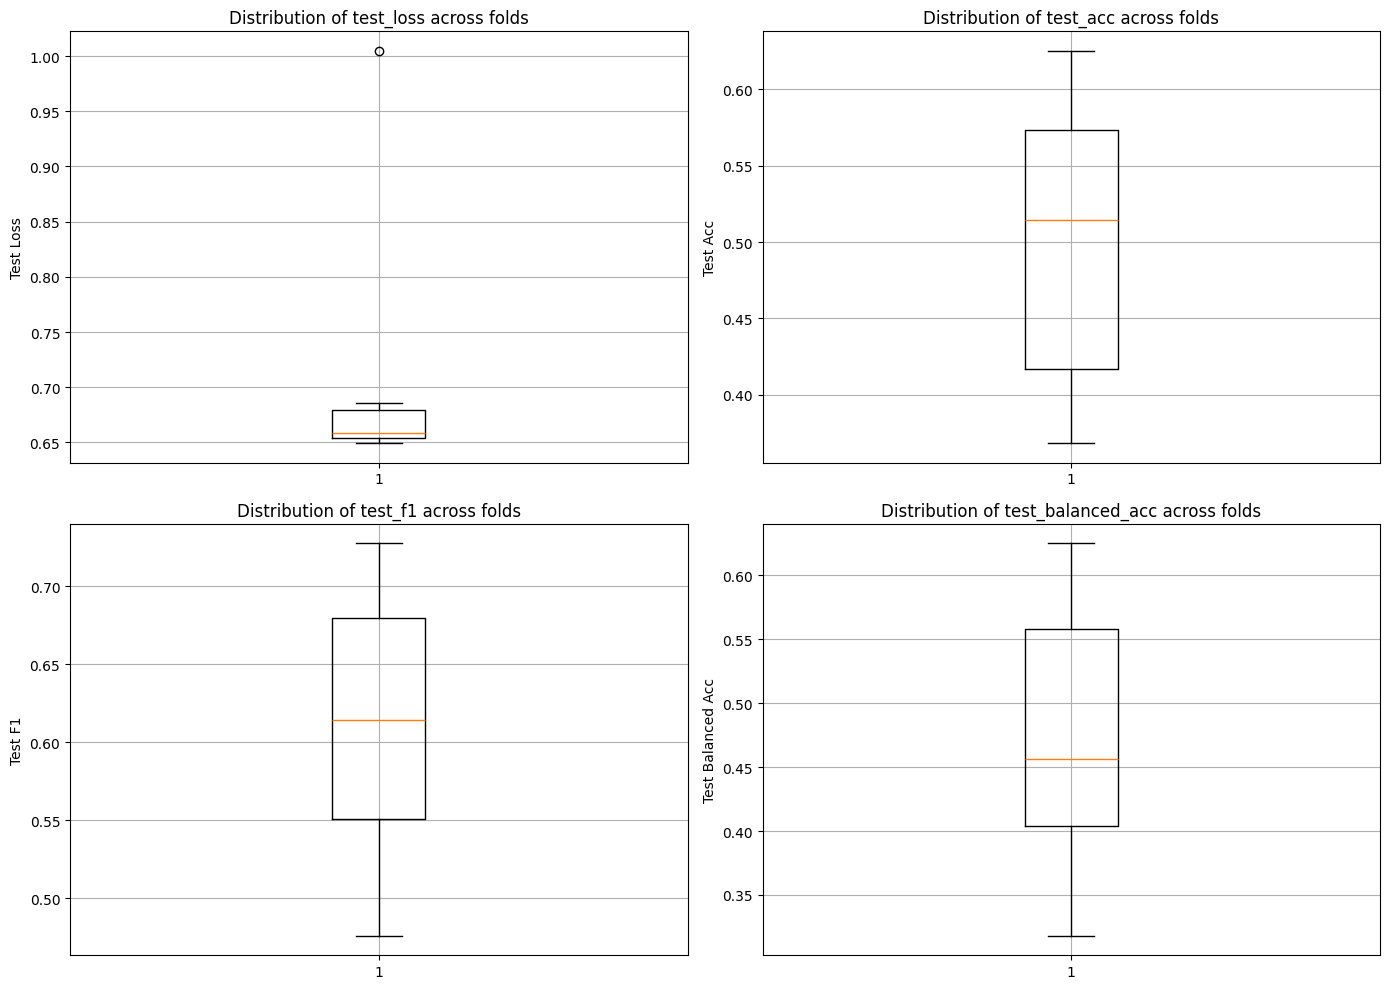

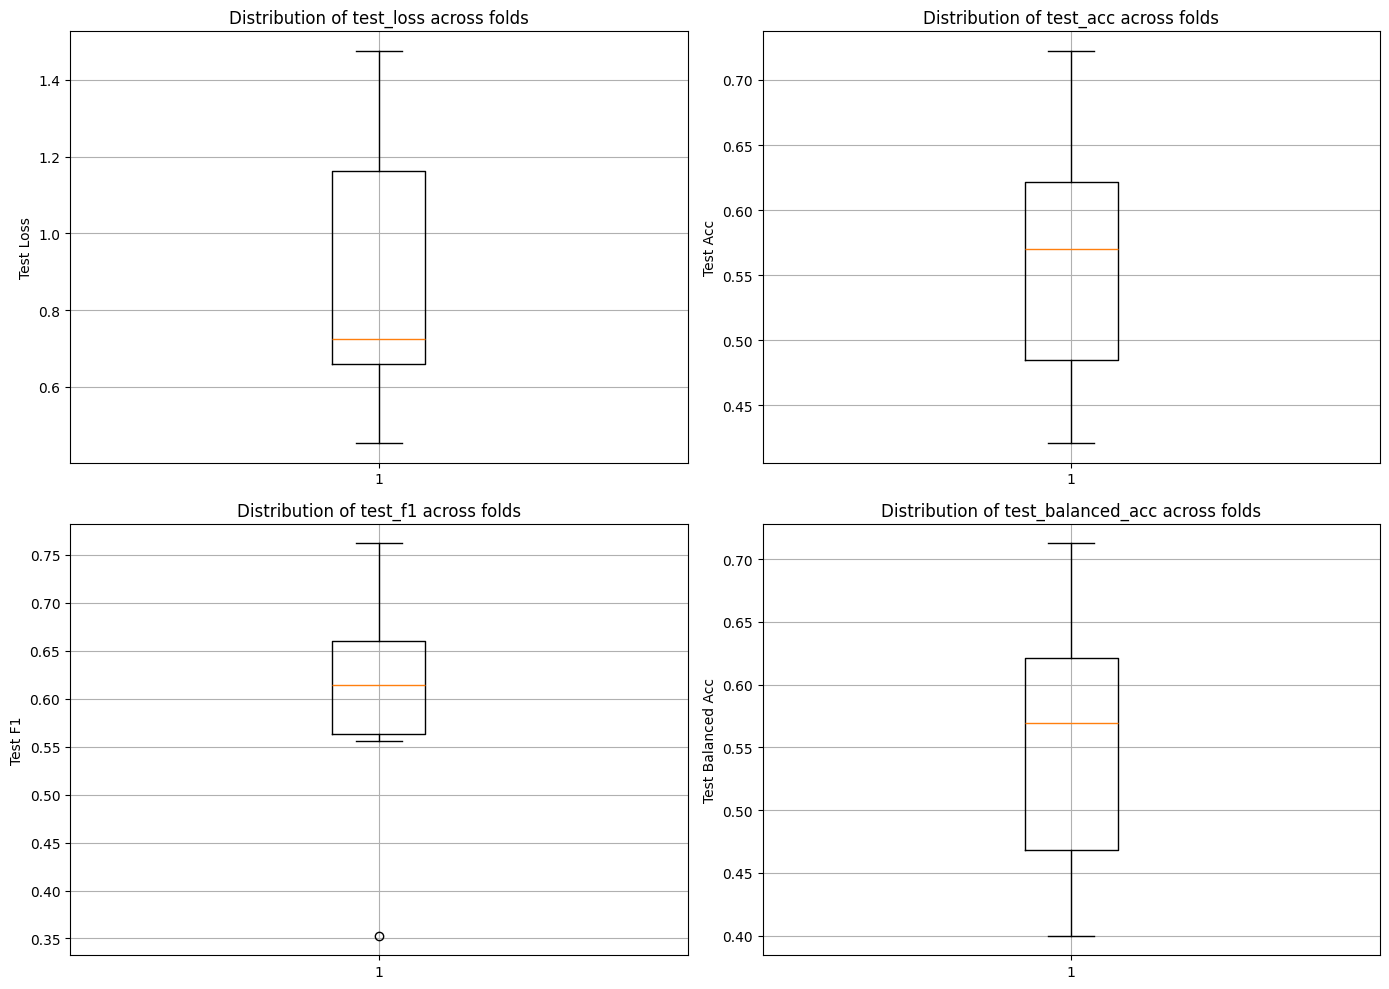

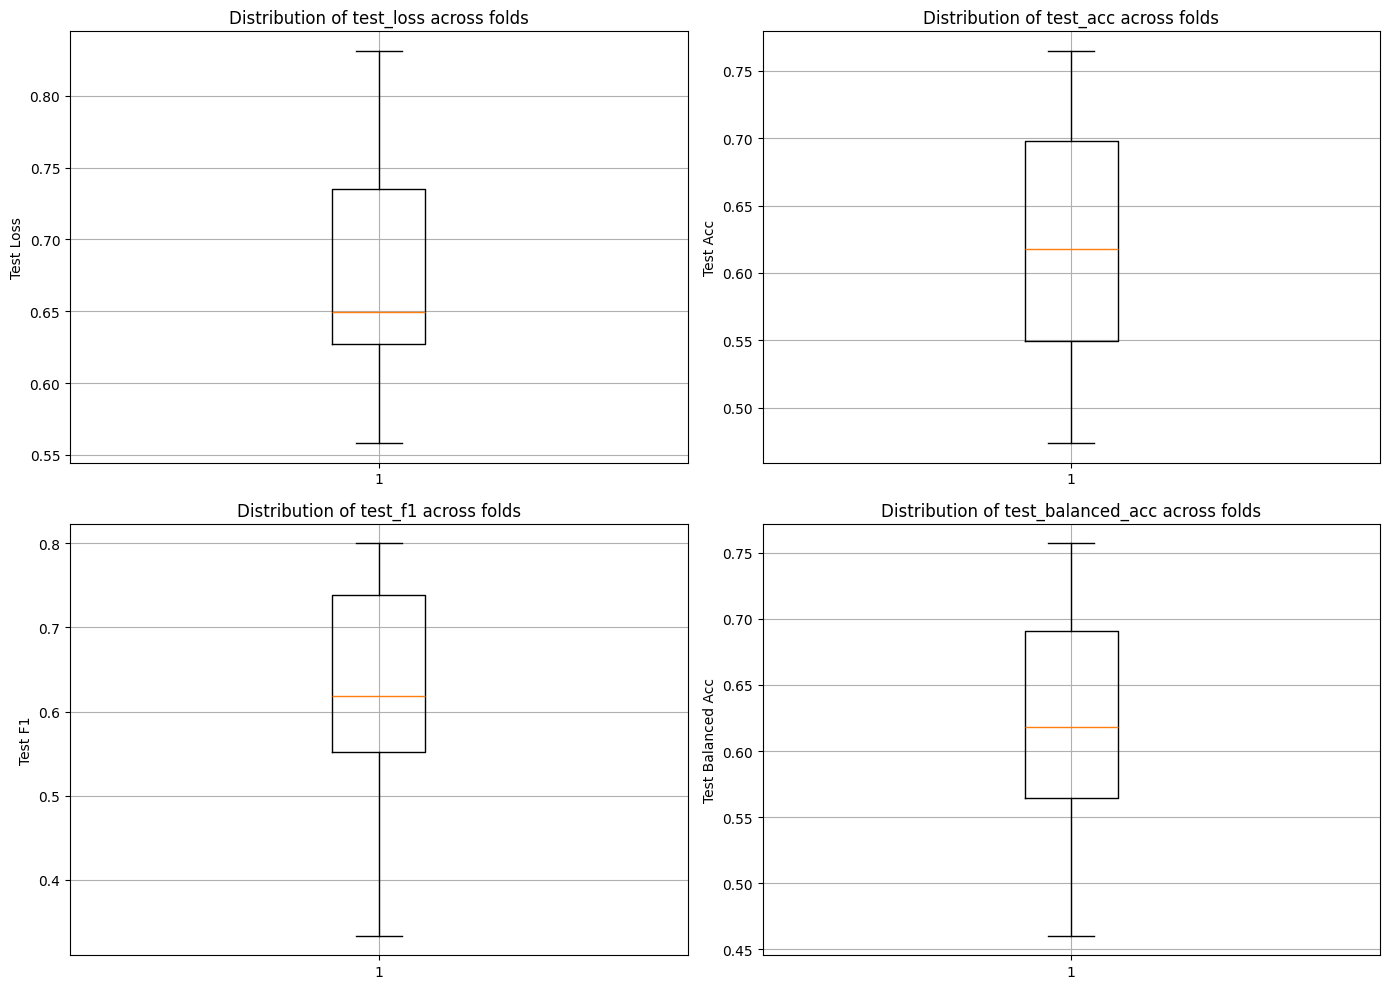

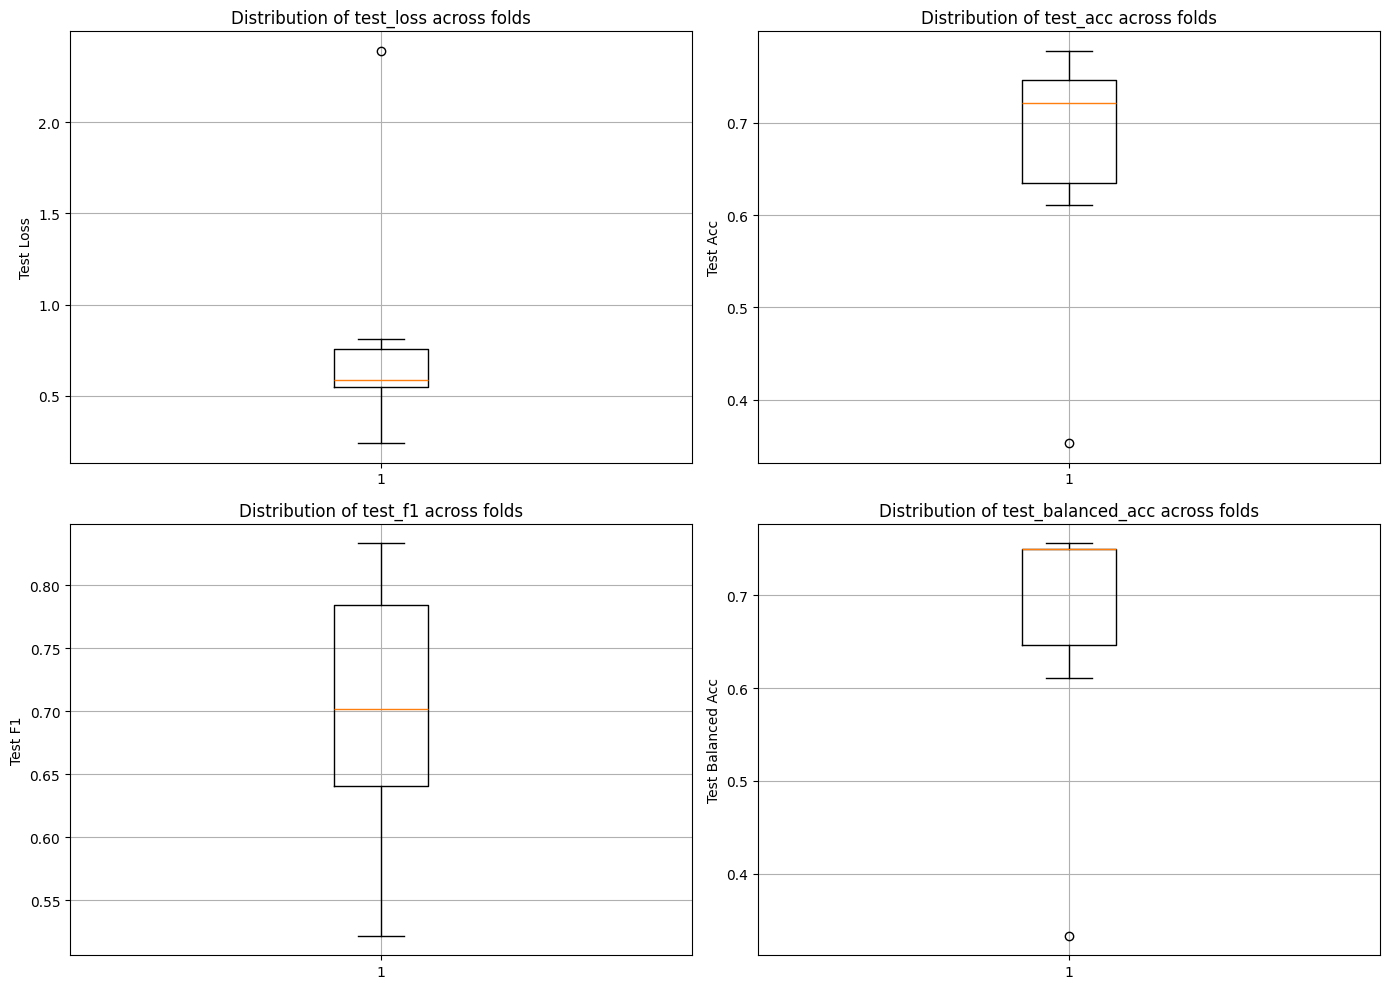

In [46]:
from utils.train_functions import BaseSSLClassifier, SSLClassifierModule, nested_cv_stratified_by_patient, solve_cuda_oom
import copy
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER= True  # Set to True if you want to freeze the encoder
encoders = [byol_encoder, byol_encoder_notPretrained]
bool_list = [True, False] 
for encoder in encoders:
    for FREEZE_ENCODER in bool_list:
        if encoder == byol_encoder:
            if simsiam:
                encoder_type = "SimSiam"
            else:
                encoder_type = "BYOL"
        else:
            encoder_type = "NOSSL"
            
        def model_factory(lr: float)-> torch.nn.Module:
            """
        Model‐factory that instantiates a fresh SSLClassifierModule
        with the given learning rate.
        """
            fresh_encoder = copy.deepcopy(encoder)
            return SSLClassifierModule(
                encoder=fresh_encoder,     # capture this from your outer scope
                num_classes=2,
                freeze_encoder=FREEZE_ENCODER,
                lr=cfg.get_learning_rate(),
                backbone_output_dim=feats.shape[1],
                # input_shape=input_shape= (1, num_input_channels, 256, 256),  # Adjust as needed (B, C, H, W)
            )

        from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
        # cfg.set_freezed_layer_index(None)
        experiment = NestedCVStratifiedByPatient(
            df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
            pretrained_weights = pretrained_weights,
            class_names = class_names, model_factory=model_factory, num_folds=6
        )
        # cfg.set_freezed_layer_index(None)
        # hold_out_cv = True
        using_cosine_scheduler = False

        per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


        from utils.mlflow_functions import log_SSL_run_to_mlflow
        def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
            """
            Get the index of the best fold based on a specified metric.

            Args:
                outer_fold_test_results (list of dict): List containing test results for 
                    each outer fold. Each element should be a dictionary with metrics 
                    as keys.
                metric (str): The metric name to use for selecting the best fold. 
                    Default is "test_balanced_acc".

            Returns:
                int: The index of the fold with the highest value for the specified metric.

            Example:
                best_idx = get_best_fold_idx(results, metric="test_f1")
            """

            print(outer_fold_test_results)
            best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
            # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
            best_fold_result = outer_fold_test_results[best_fold_idx]
            print(f"Best {metric} Fold Result: {best_fold_result}")
            fold_idx = best_fold_result["fold"]
            return fold_idx

        #loading the best model for the metric selected, it's then used for computing gradcams during logging
        best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
        model_instance_for_logging, _ = experiment._get_model_and_device()
        model_instance_for_logging.eval()
        try:
            model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
        except FileNotFoundError:
            raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
        except Exception as e:
            raise Exception(f"Error loading model weights: {str(e)}")

        # Now, call the logging function:
        train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
        # Now, call the logging function:
        # or "moco" if using MoCo
        log_SSL_run_to_mlflow(
            environmentFlags=environment_flags,
            cfg=cfg,
            model=model_factory(0.001),  # Pass a dummy model to log the run
            class_names=class_names,
            fold_results=outer_fold_test_results,
            per_fold_metrics=per_fold_training_metrics,
            hold_out_cv=True,
            test_transforms=val_transforms,
            all_images_paths_np=images_paths_np,
            all_labels_np=labels_np,
            test_images_paths_np=test_images_paths_np,
            test_true_labels_np=test_true_labels_np,
            yaml_path=yaml_path,
            color_transforms=color_transforms,
            model_library=model_library,
            encoder_type= encoder_type,
            pretrained_backbone_path = STABLE_BACKBONE_PATH,
            train_transforms=train_transforms,
            # val_transforms=val_transforms,
            freeze_encoder= FREEZE_ENCODER,
            ssl=True,
        )
        solve_cuda_oom()